# A/B-тестирование

Конспект основных положений по теме А/В-тестирования

In [1]:
import pandas as pd
import numpy as np
import math

import pingouin as pg
from scipy import stats
from scipy.integrate import simpson
from statsmodels.stats.power import tt_ind_solve_power

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from datetime import datetime as dt
from datetime import timedelta as td

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from IPython.display import Image

pd.set_option('display.max_columns', 50, 'display.float_format', lambda x: '%.2f' % x)

sns.set(
    font_scale = 2,
    style      = "whitegrid",
    rc         = {'figure.figsize':(12,6),
                  'lines.marker': 'o',
                  "axes.labelsize":10,
                  "xtick.labelsize": 8,
                  "ytick.labelsize": 8,
                  "axes.titlesize":12,
                  "legend.fontsize":10,
                  "legend.title_fontsize":10,
                  "font.size":10}
)

%matplotlib inline

cm_green = sns.color_palette("blend:white,green", as_cmap = True)
cm_red = sns.color_palette("blend:white,red", as_cmap = True)
cm_red_green = sns.color_palette("blend:red,white,green", as_cmap = True)

#plt.rcParams.keys()

# Планирование экспериментов

Общий порядок проведения AB-тестов включает следующие этапы:
1) **Сбор бизнес-аспектов** - определение проблемы, оценка рисков, учёт ограничений, сбор обратной связи об ожиданиях. 
2) **Дизайн эксперимента** - выбор метрик (целевых, прокси, заградительных, инфо); выбор сегмента, для которого будет проводиться эксперимент; определение MDE, требуемого объёма выборки, стат. критерия.
3) **Запуск и проведение эксперимента** - контроль корректности проведения с точки зрения пользовательского пути, контроль заградительных метрик.
4) **Подведение итогов эксперимента** - интерпретация полученных результатов, предложения по улучшению.
5) **Завершение эксперимента** - фиксация результатов эксперимента в базе знаний, чистка кодовой базы.

## Этап 1. Сбор бизнес-аспектов

**Цель этапа**: убедиться, что гипотеза согласована со стратегией и целями бизнеса. 

Этот этап включает в себя:
* **Определение проблематики** - какую проблему ожидается решить предложенной инициативой (более широко: какие в целом проблемы беспокоят бизнес, зачем необходимо внедрять инициативу?)
* **Формулировка гипотезы** - её стоит формулировать по следующей схеме: **ЕСЛИ** (сделать то-то) **ДЛЯ** (такого-то сегмента пользователей), **ТО** (это повлияет на метрики так-то), **ПОТОМУ ЧТО** (поведение пользователей изменится так-то).
* **Оценка целесообразности** - валидация гипотезы с точки зрения того, насколько ожидаемый эффект может окупить затраты. Для оценки следует ответить на следующие вопросы:
    * Может ли положительный эффект от этой инициативы окупить 10 других экспериментов (в среднем, только 1 A/B эксперимент из 10 является удачным). Затраты на эксперименты включают затраты на разработку и маркетинг (если они есть);
    * Есть ли более перспективные и приоритетные гипотезы?
* **Оценка рисков** - учёт негативных последствий от проведения эксперимента. Часто могут возникать такие последствия:
    * _Финансовые_ - если падает целевая метрика, то следует оценить, какие потери бизнес понесёт и какой их уровень является приемлемым.
    * _Репутационные_ - если в негативную сторону меняется опыт пользователя, какой может быть отток.
    * _Негативный долгосрочный эффект_ - когда краткосрочно можно получить выгоду, но в долгосроке будет происходить отток и снижение LTV. 
    
    Высокий уровень рисков может означать, что траффик под эксперимент необходимо выделять в сокращённом объёме. 
* **Оценка ограничений** - учёт объективных факторов, из-за которых эксперимент не может быть проведён, либо может быть проведён с изменениями по сравнению с базовым вариантом (базовый = как он выполнялся бы без этих ограничений).
    * _PR_ - насколько об изменении могут быть проинформированы пользователи, входящие в контрольную группу? Если они могут об этом узнать раньше, то условия будут нарушены.
    * _Юридические_ - запреты на определённые стратегии ценообразования, использование персональных данных и т.п.
    * _Технические_ - платформа и инфраструктура для экспериментов, в том числе для большого траффика, если он ожидается; пропускная способность других "звеньев" пользовательского пути.
    * _Сетевой эффект_ - когда экспериментальная группа влияет на поведение контрольной, это искажает результаты.
    * _Бизнесовые_ - если в отношении новой функциональности есть обязательства у бизнеса по отношению к другим лицам и другие случаи.

После сбора этой информации принимается решение о том, будет ли проводиться эксперимент. Если проводить A/B-тест нет возможности, то могут рассматриваться альтернативные методы: **PSM**, **DiD**, **Causal Impact** и др. 

В целом, A/B-тесты ещё рано проводить, когда в компании мало клиентов, т.к. будут набираться маленькие выборки (A/B могут успешно проводиться уже при выборках от 100 000 пользователей), либо когда в компании нет ресурсов на разработку и поддержание инфраструктуры, связанной с их внедрением. Если это не актуально, то A/B будет предпочтительным выбором, т.к. он позволяет контролировать риски и учитывать изменения быстро и с высокой точностью. 

Если решено, что A/B будет проводиться, то необходимо пройти ещё два шага. 

* **Определение критериев успеха** - получение ответов на вопросы:
    * в чём конкретно проявляется успех гипотезы?
    * какие метрики и на сколько должны измениться, чтобы принять решение об успешности эксперимента?
    * какие метрики, даже если они снизятся, не будут иметь значение для успеха?
  
  При ответах на этих вопросы должны закладываться заранее возможные **сценарии** событий. 

* **Формирование плана действий** - исходя из рассмотренных на предыдущем этапе сценариев определяется, какие будут приняты решения в случае реализации каждого из них:
    * Если одна метрика значимо выросла, другая значимо снизилась;
    * Если метрики выросли, но не значимо;
    * Если метрики снизились, но не значимо;
    * Если метрики снижаются значимо, то на какой день прекращаем эксперимент;
    * и т.д.

## Этап 2. Дизайн

**Цель этапа**: финализировать все условия (бизнесовые, продуктовые, статистические) для проведения эксперимента, учитывая неочевидные случаи. 

* **Анализ макетов** - чтобы получить визуальное представление, что будет меняться и как будут вести себя пользователи; убедиться, что для разных экранов / разных устройств предусмотрены различные отображения. 
* **Особенности технической реализации** - всплывающие экраны, задержки в обработке, логирование событий на бэкенде.
* **Подготовка разметки** - логирование действий пользователя, которые важно отслеживать и затем оценивать; проверка того, что оно происходит единообразно в контрольной и тестовой группах.
* **Определение сегмента** - т.е. на какой группе пользователей будет проводиться эксперимент (по гео / типам пользователей (новые, повторные) / видам устройств / версиям / источникам траффика / пользовательским параметрам).
* **Организация формирования выборки** - какая единица выборки (пользователь, сессия, заказ и т.д.); в каком слое и на каком слоте эксперимент, будут ли проводиться параллельные эксперименты; если будут, нет ли с ними пересечений и конфликтов.
* **Выбор метрик**

|Тип метрики|Цель|Как подбирается|
|---|---|---|
|Ключевая|Основной критерий определения успешности эксперимента|Исходя из основной гипотезы|
|Прокси|Альтернативный критерий успешности, на случай если ключевая метрика может запаздывать|Определяется через действия, которые сигнализируют о намерениях к совершению целевого действия, опережая его|
|Заградительная|Учёт рисков|Подбираются как результат оценки рисков, как метрики, наиболее подверженные самым вероятным рискам|
|Информационная|Получение дополнительной информации и выдвижение новых гипотез на базе эксперимента|Должны отражать поведенческие паттерны пользователей относительно тестируемой функциональности|

    После выбора метрик сразу определяется стат. критерий, который будет использоваться для оценки.
  
*  **Подбираем соотношение групп**
    * 50/50 - наибольшая мощность и наименьшее время эксперимента; можно нанести урон продукту, если поведение пользователей будет отличаться от ожидаемого, либо из-за технических ошибок;
    * 90/10 - снижение мощности, требуется больше времени для сбора данных, но ниже риски.
*  **Считаем длительность эксперимента** - для каждой метрики принимается решение об уровне мощности и стат. значимости, затем вычисляются
    *   MDE
    *   минимальный объём выборки
    *   уровень траффика
    *   на основе траффика и минимального объёма выборки считается минимальная длительность эксперимента
    *   принимается решение, подходит ли вычисленная длительность эксперимента или требуется её скорректировать.

Если вычисленная длительность эксперимента не подходит (слишком длинная), то решается, нужны ли техники сокращения дисперсии, увеличения MDE или изменения метрики (на прокси- или другую прокси-). В крайнем случае может быть выбрана другая гипотеза.

**Подбор MDE** - к нему можно подходить с нескольких сторон:
* Рассматривать эффект при заданном MDE как величину возврата на инвестиции (на 10 других A/B-тестов);
* Как планируемый темп роста (в случае стартапа с большим количеством инициатив);
* На основе исторических данных - как часто в экспериментах удавалось достичь роста метрики и на сколько;
* На основе того, сколько времени отводится на эксперимент и какой размер MDE за это время реально обнаружить.
* На основе результатов экономической оценки бизнес-эффекта.

Можно комбинировать несколько вариантов. 

**Проверка учёта других нюансов**
* **Эффекта новизны и сопротивления новому** 
    * будут ли старые пользователи возражать против нововведений, что может перерасти в сетевой эффект?
    * будет ли повышенный, но при этом поверхностный интерес к новой фиче, не приводящий к целевым действиям? В таком случае следует подбирать другую метрику, менее чувствительную к первичным действиям.
* **Возможность подглядывания** - будет ли предусмотрено досрочное решение о завершении эксперимента или его прекращении? Если да, то какие ошибки 1-го и 2-го рода будут при завершении эксперимента на день Х, на сколько они вырастут?
* **Сезонность продукта** - пользователи могут вести себя по разному в разные периоды (будни / выходные / праздники). Длительность эксперимента нужно подбирать равной сезонным циклам или избегать проводить в периоды изменения нормальных паттернов.
* **Окно конверсии** - сколько времени пользователю нужно, чтобы совершить целевое действие (в случае триал-продуктов, промо-предложений).
* **Выбросы** - какая доля "китов" в продукте и в дневном траффике, как они влияют на дисперсию? Какова вероятность технических ошибок, из-за которых могут регистрироваться сверхдлинные сессии? Первые нужно учитывать в оценке, вторых можно исключать из эксперимента.
* **Проблема множественного сравнения** - если оценивается несколько метрик, то необходимо корректировать уровень $\alpha$.

Перед запуском теста следует:
* провести А/А-тест, чтобы убедиться в корректном разделении траффика;
* убедиться, что реализация изменения совпадает с ТЗ (дизайн совпадает с макетами / механика совпадает с ожидаемой);
* продукт прошёл регрессионное тестирование и тестирование ответственным продактом и аналитиком;
* нет конфликтов с другими экспериментами (нет незапланированных экспериментов в том же слое и нет экспериментов, которые могут занять тот же слот);
* пересмотрен и уточнён план действий с учётом возможных изменений.

## Этап 3. Запуск и проведение

**Цель этапа**: убедиться, что все данные по эксперименту собираются корректно и/или гипотеза не начала приносить неожиданный вред продукту. 

**После запуска** некоторое время необходимо мониторить метрики, чтобы подтвердить, что:
* технические баги отсутствуют;
* логирование выполняется корректно во всех группах эксперимента;
* пользователи репрезентативны, т.е. случаным образом распределяются в группы (т.е. должно быть одинаковое распределение пользователей между группами по различным критериям - устройства, тип пользователя, характеристики пользователя и т.п.) 
* соотношение размеров выборок соответствует тому, который закладывался в дизайн;
* нет резких падений или улучшений метрик - в обоих случаях это сигнал о проблемах;
* пользователи не переходят между группами (такое может провляться, например, при экспериментах в "неавторизованной зоне", когда пользователь ещё не авторизовался и не имеет постоянного id).

**На этапе проведения** дополнительно необходимо проверить, что у пользователей не возникает эффекта новизны или непринятия нового (либо, если он ожидается - следить за тем, как он проявляется).

## Этап 4. Подведение итогов

**Цель этапа**: анализ результатов, выводы, презентация результатов и рекомендации. 

* Повторная проверка всех условий, перечисленных в п.3;
* Проверка результатов на стат. значимость;
* Проверка того, что полученные результаты соотносятся с результатами других экспериментов, стратегией и общим видением бизнеса;
* Формулирование ответов на изначальные вопросы, кратких выводов и рекомендаций;
* Документирование результатов для менеджмента (executive summary). 

## Этап 5. Завершение

**Цель этапа**: убедиться, что выполнен план и закрыть тест.

* Убедиться, что эксперимент раскатили / откатили;
* Занести результаты теста в базу знаний;
* Поставить задачу на исключение эксперимента из кода продукта и снятие feature flags с пользователей;
* Убедиться, что после раскатки эксперимента метрики ведут себя как ожидается.

## Оценка вероятности ошибки 1-го и 2-го рода

**Ошибка 1-го рода** - это вероятность отвергнуть нулевую гипотезу при условии, что она верна. 

**Ошибка 2-го рода** - это вероятность *не отвергнуть* нулевую гипотезу при условии, что верна альтернативная гипотеза.

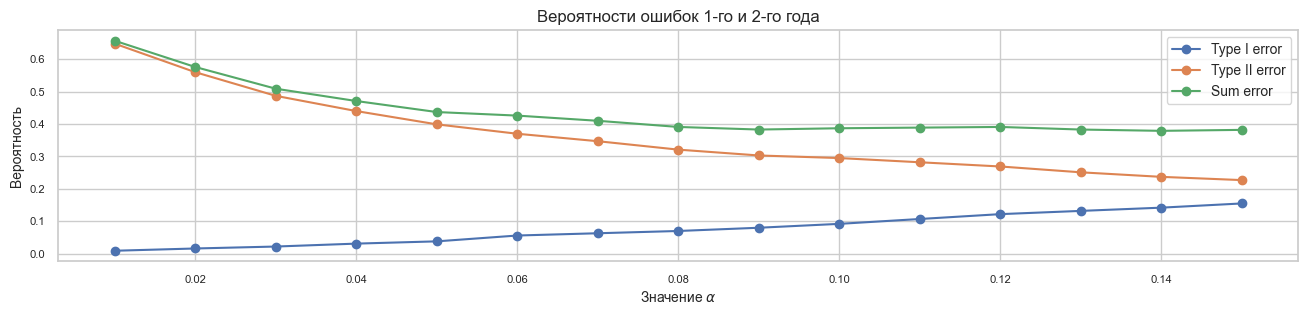

In [97]:
# Вероятности ошибок в зависимости от выбранного уровня значимости

iter = 1000
size = 1000
eff = 0.1

ttest_H0_pval = []
ttest_H1_pval = []

for _ in tqdm(range(iter)):
    v1, v2, v_eff = np.random.randn(size), np.random.randn(size), np.random.randn(size)+eff
    ttest_H0 = pg.ttest(v1, v2)
    ttest_H1 = pg.ttest(v1, v_eff)
    ttest_H0_pval.append(ttest_H0['p-val'][0])
    ttest_H1_pval.append(ttest_H1['p-val'][0])

alpha_iter = np.linspace(0.01, 0.15, 15)

prob_H0_pval = []
prob_H1_pval = []

for val in alpha_iter:
    cnt = (np.array(ttest_H0_pval) < val).sum()
    prob = cnt / len(ttest_H0_pval)
    prob_H0_pval.append(prob)
    cnt = (np.array(ttest_H1_pval) > val).sum()
    prob = cnt / len(ttest_H1_pval)
    prob_H1_pval.append(prob)

fig, ax = plt.subplots(figsize = (16,3))
ax.plot(alpha_iter, prob_H0_pval, label='Type I error')
ax.plot(alpha_iter, prob_H1_pval, label='Type II error')
ax.plot(alpha_iter, np.sum([prob_H0_pval, prob_H1_pval], axis=0), label='Sum error')
ax.set(xlabel=r'Значение $\alpha$', ylabel='Вероятность', title='Вероятности ошибок 1-го и 2-го года')
ax.legend()
fig.show()

Когда решение принимается на основе p-value, и: 
* отличий на самом деле нет, то вероятность ошибки 1-го рода прямо пропорциональна уровню значимости. 
* отличия на самом деле есть, то вероятность ошибки 2-го рода снижается с увеличением уровня значимости.

Таким образом, уровень значимости в общем случае необходимо выбирать так, чтобы минимизировать обе ошибки, либо суммарную ошибку (или функцию от них, если она приоритетнее другой). Если брать критерий суммарной ошибки, то оптимальный уровень значимости был бы 0,09.

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [04:21<00:00,  7.91s/it]


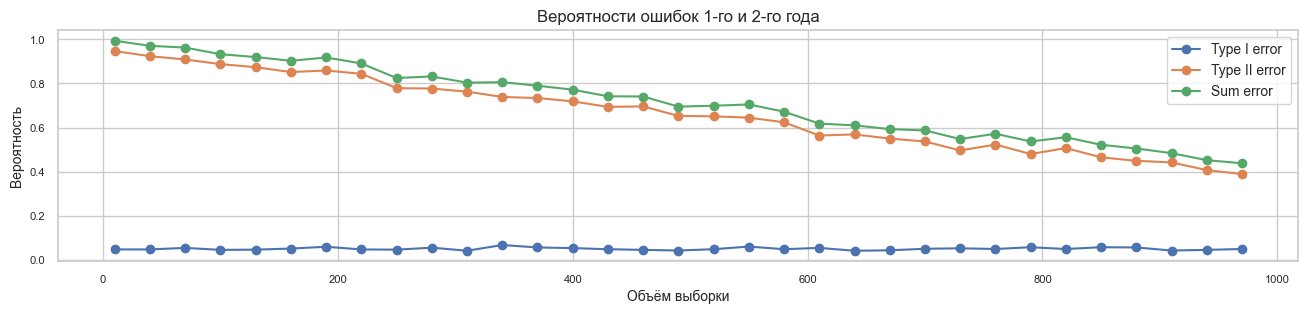

In [122]:
# Вероятности ошибок в зависимости от объёма выборки

iters = 1000
alpha = 0.05
size = np.arange(10, 1000, 30)
eff = 0.1

size_H0_pval = []
size_H1_pval = []

for s in tqdm(size):
    
    prob_H0_pval = []
    prob_H1_pval = []
    
    for _ in range(iters):
        v1, v2, v_eff = np.random.randn(s), np.random.randn(s), np.random.randn(s)+eff
        ttest_H0 = pg.ttest(v1, v2)
        ttest_H1 = pg.ttest(v1, v_eff)
        false_positive = ttest_H0['p-val'][0] < alpha
        false_negative = ttest_H1['p-val'][0] > alpha
        prob_H0_pval.append(false_positive)
        prob_H1_pval.append(false_negative)

    size_H0_pval.append(np.mean(prob_H0_pval))
    size_H1_pval.append(np.mean(prob_H1_pval))


fig, ax = plt.subplots(figsize = (16,3))
ax.plot(size, size_H0_pval, label='Type I error')
ax.plot(size, size_H1_pval, label='Type II error')
ax.plot(size, np.sum([size_H0_pval, size_H1_pval], axis=0), label='Sum error')
ax.set(xlabel='Объём выборки', ylabel='Вероятность', title='Вероятности ошибок 1-го и 2-го года')
ax.legend()
fig.show()

При фиксированном уровне значимости вероятность ошибки 1-го рода не меняется с ростом объёма выборки.

Вероятность ошибки 2-го рода с ростом объёма выборки линейно снижается, как и суммарная ошибка. 

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [04:06<00:00,  8.20s/it]


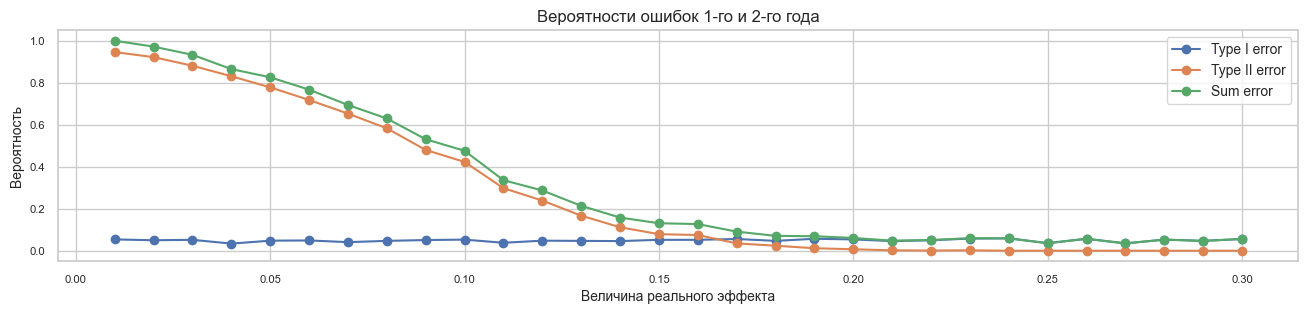

In [128]:
# Вероятности ошибок в зависимости от величины эффекта

iter = 1000
alpha = 0.05
size = 1000
eff = np.linspace(0.01, 0.3, 30)

eff_H0_pval = []
eff_H1_pval = []

for e in tqdm(eff):
    
    prob_H0_pval = []
    prob_H1_pval = []
    
    for _ in range(iter):
        v1, v2, v_eff = np.random.randn(size), np.random.randn(size), np.random.randn(size)+e
        ttest_H0 = pg.ttest(v1, v2)
        ttest_H1 = pg.ttest(v1, v_eff)
        false_positive = ttest_H0['p-val'][0] < alpha
        false_negative = ttest_H1['p-val'][0] > alpha
        prob_H0_pval.append(false_positive)
        prob_H1_pval.append(false_negative)

    eff_H0_pval.append(np.mean(prob_H0_pval))
    eff_H1_pval.append(np.mean(prob_H1_pval))


fig, ax = plt.subplots(figsize = (16,3))
ax.plot(eff, eff_H0_pval, label='Type I error')
ax.plot(eff, eff_H1_pval, label='Type II error')
ax.plot(eff, np.sum([eff_H0_pval, eff_H1_pval], axis=0), label='Sum error')
ax.set(xlabel='Величина реального эффекта', ylabel='Вероятность', title='Вероятности ошибок 1-го и 2-го года')
ax.legend()
fig.show()

Вероятность ошибки первого рода не меняется с изменением реальной величины эффекта. 

В то же время, вероятность ошибки 2-го рода довольно высокая при малых значениях реального эффекта. Чем эффект выше, тем это вероятность ниже.

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:37<00:00,  7.89s/it]


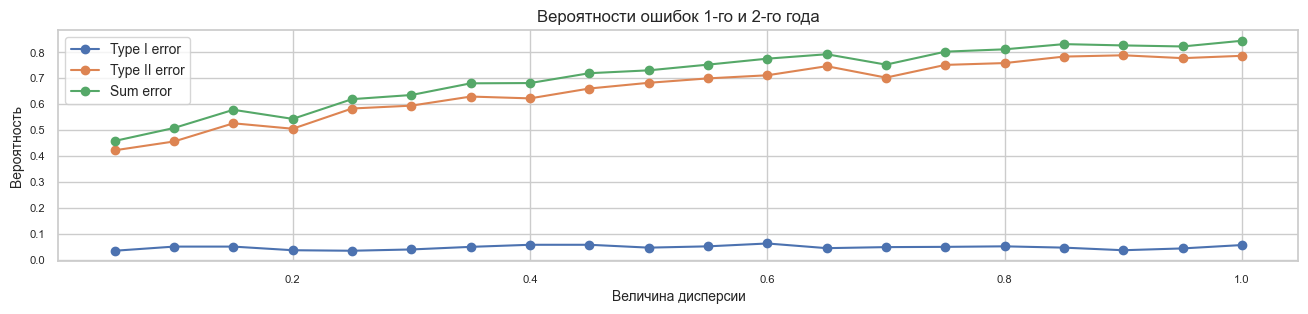

In [133]:
# Вероятности ошибок в зависимости от величины дисперсии

iter = 1000
alpha = 0.05
size = 1000
eff = 0.1
disp = np.linspace(0.05, 1, 20)

disp_H0_pval = []
disp_H1_pval = []

for var in tqdm(disp):
    
    prob_H0_pval = []
    prob_H1_pval = []
    
    for _ in range(iter):
        v1, v2, v_eff = np.random.normal(0, 1+var, size), np.random.normal(0, 1+var, size), np.random.normal(0, 1+var, size)+eff
        ttest_H0 = pg.ttest(v1, v2)
        ttest_H1 = pg.ttest(v1, v_eff)
        false_positive = ttest_H0['p-val'][0] < alpha
        false_negative = ttest_H1['p-val'][0] > alpha
        prob_H0_pval.append(false_positive)
        prob_H1_pval.append(false_negative)

    disp_H0_pval.append(np.mean(prob_H0_pval))
    disp_H1_pval.append(np.mean(prob_H1_pval))


fig, ax = plt.subplots(figsize = (16,3))
ax.plot(disp, disp_H0_pval, label='Type I error')
ax.plot(disp, disp_H1_pval, label='Type II error')
ax.plot(disp, np.sum([disp_H0_pval, disp_H1_pval], axis=0), label='Sum error')
ax.set(xlabel='Величина дисперсии', ylabel='Вероятность', title='Вероятности ошибок 1-го и 2-го года')
ax.legend()
fig.show()

Таким образом, в случае нормального распределения вероятность ошибки 2-го рода можно записать следующим образом:
$$\beta = cdf(z(\alpha, \mu_1, \sigma_1), \mu_2, \sigma_2)$$

где: $\alpha$ - уровень значимости, $\mu_1$ и $\mu_2$ - мат. ожидания распределений, $\sigma_1$ и $\sigma_2$ - стандартные отклонения распределений, $cdf$ - кумулятивная функция распределения, $z$ - z-статистика для заданных параметров. 

Таким образом, на вероятности ошибок факторы влияют следующим образом:

| Фактор \ Ошибка | I рода | II рода |
| --- | --- | --- |
| Уровень значимости ↑ | ↑ | ↓ |
| Объём выборки ↑ | ↔ | ↓ |
| Размер эффекта ↑ | ↔ | ↓ |
| Величина дисперсии ↑ | ↔ | ↑ |

## Расчёт вероятности ошибки I и II рода на основе распределений

In [10]:
alpha = 0.05
iter = 100
size = np.linspace(100, 10000, 300)
e = 0.07

mpl.use('Agg')
H0_z_alpha = stats.norm(loc=0, scale=1).ppf(1-alpha)
beta = stats.norm(loc=0.07, scale=1).cdf(H0_z_alpha)

# расчёт вероятности ошибки I рода

area = []
for _ in tqdm(range(iter)):
    v1 = np.random.randn(size)
    fig, axes = plt.subplots()
    axes = sns.kdeplot(v1)
    
    line_1 = axes.lines[0]
    line_1x, line_1y = line_1.get_xdata(), line_1.get_ydata()
    coords = pd.DataFrame([line_1x, line_1y], index = ['z', 'p']).T
    x_data, y_data = coords[coords['z'] > np.quantile(v1, 1-alpha)]['z'].values, coords[coords['z'] > np.quantile(v1, 1-alpha)]['p'].values
    area.append(simpson(y_data, x_data))

calc_alpha = np.round(np.mean(area), 3)
alpha_diff_perc = np.round((calc_alpha / alpha - 1) * 100,3)

# расчёт вероятности ошибки II рода

area = []
for _ in tqdm(range(iter)):
    v1, v_eff = np.random.randn(size), np.random.randn(size)+e

    fig, axes = plt.subplots()
    axes = sns.kdeplot(v1)
    axes = sns.kdeplot(v_eff)

    line_1, line_eff = axes.lines[0], axes.lines[1]
    line_1x, line_1y = line_1.get_xdata(), line_1.get_ydata()
    line_effx, line_effy = line_eff.get_xdata(), line_eff.get_ydata()

    coords = pd.DataFrame([line_effx, line_effy], index = ['z', 'p']).T
    x_data, y_data = coords[coords['z'] > np.quantile(v1, 1-alpha)]['z'].values, coords[coords['z'] > np.quantile(v1, 1-alpha)]['p'].values
    area.append(simpson(y_data, x_data))

power = np.mean(area)
calc_beta = np.round(1-power,3)
beta_diff_perc = np.round((calc_beta / beta - 1) * 100,3)
print(f'Вероятность ошибки I рода на выборочных данных: {calc_alpha}, отклонение от теоретического уровня: {alpha_diff_perc}%')
print(f'Вероятность ошибки II рода на выборочных данных: {calc_beta}, отклонение от теоретического уровня: {beta_diff_perc}%')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.50it/s]


Вероятность ошибки I рода на выборочных данных: 0.05, отклонение от теоретического уровня: 0.0%
Вероятность ошибки II рода на выборочных данных: 0.942, отклонение от теоретического уровня: -0.038%


## Оценка размера выборки и MDE

Когда реальный эффект известен, то величина ошибки 2-го рода определяется эмпирически. 

Но обычно реальный эффект не известен. В таком случае, регулируя объём выборки и предполагаемый эффект, можно добиться, чтобы ошибка II рода совершалась не чаще заданного порога. 

### Оценка минимального размера выборки

In [47]:
eff = 0.5
alpha = 0.05
beta = 0.2
mu = 100
sigma = 2

iters = 200
size = np.arange(100, 300, 1)
n_obs = pd.DataFrame([size, np.zeros(len(size))], index = ['n_obs', 'significant']).T

n_size = []
for s in tqdm(size):
    type_2_error = 0
    for _ in range(iters):
        H0_dist, H1_dist = np.random.normal(mu,sigma,int(s)), np.random.normal(mu,sigma,int(s))+eff
        ttest = pg.ttest(H0_dist, H1_dist)
        if ttest['p-val'].values[0] > alpha:
            type_2_error += 1
    beta_obs = type_2_error / iter
    if beta_obs < beta:
        n_obs.loc[n_obs['n_obs'] == s, 'significant'] = 1

obs_min = n_obs.query('significant == 1')['n_obs'].min()
compute_size = np.round(tt_ind_solve_power(effect_size = eff / sigma, 
                                           nobs1=None, alpha=0.05, power=1-beta, ratio=1.0, alternative='two-sided'),0)

print(f'Вычислительная оценка необходимого объёма выборки для каждой группы (на основе t-теста): {compute_size}')
print(f'Симуляционная оценка минимального объёма выборки для каждой группы: {obs_min}')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:38<00:00,  1.26it/s]

Вычислительная оценка необходимого объёма выборки для каждой группы (на основе t-теста): 252.0
Симуляционная оценка минимального объёма выборки для каждой группы: 228.0


Итерация 1: Доля ошибок I рода: 5.1%, II рода: 21.1%
Итерация 2: Доля ошибок I рода: 6.2%, II рода: 21.9%
Итерация 3: Доля ошибок I рода: 5.1%, II рода: 19.3%
Итерация 4: Доля ошибок I рода: 4.6%, II рода: 21.6%
Итерация 5: Доля ошибок I рода: 5.7%, II рода: 18.7%
Итерация 6: Доля ошибок I рода: 4.4%, II рода: 19.7%
Итерация 7: Доля ошибок I рода: 4.0%, II рода: 19.3%
Итерация 8: Доля ошибок I рода: 4.3%, II рода: 17.3%
Итерация 9: Доля ошибок I рода: 5.5%, II рода: 20.7%
Итерация 10: Доля ошибок I рода: 5.7%, II рода: 18.2%


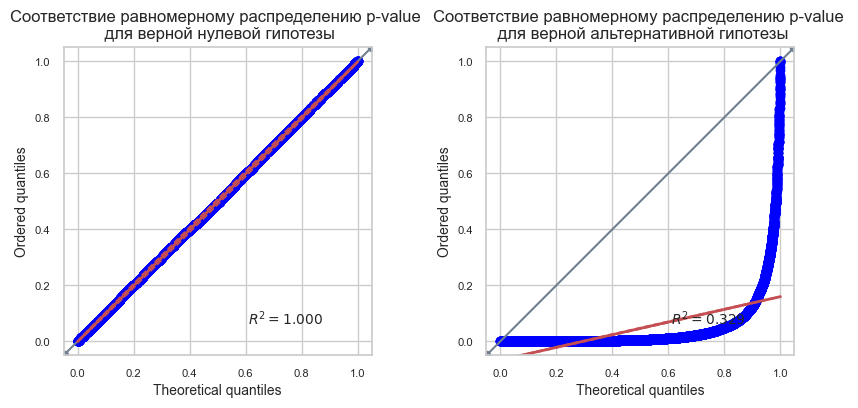

In [59]:
# проверка контролируемости ошибок I и II рода для данного размера выборки

n_sample = np.max([compute_size, obs_min]).astype(int)
iterations = 1000
AA_pvals = []
AB_pvals = []

for i in np.arange(10):
    
    counter_type1_err = 0
    counter_type2_err = 0

    for _ in np.arange(iterations):
        A1, A2, B = np.random.normal(mu, sigma, n_sample), np.random.normal(mu, sigma, n_sample), np.random.normal(mu, sigma, n_sample)+eff
        AA_test = pg.ttest(A1, A2)
        AB_test = pg.ttest(A1, B)
        
        AA_pval = AA_test['p-val'].values[0]
        AB_pval = AB_test['p-val'].values[0]

        AA_pvals.append(AA_pval)
        AB_pvals.append(AB_pval)
        
        if AA_pval < alpha:
            counter_type1_err += 1
            
        if AB_pval >= alpha:
            counter_type2_err += 1
    
    d_err_type1 = np.round(counter_type1_err / iterations * 100, 1)
    d_err_type2 = np.round(counter_type2_err / iterations * 100, 1)

    print(f'Итерация {i+1}: Доля ошибок I рода: {d_err_type1}%, II рода: {d_err_type2}%')

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0] = pg.qqplot(AA_pvals, dist='uniform', ax=axes[0])
axes[0].set(title = 'Соответствие равномерному распределению p-value \n для верной нулевой гипотезы')
axes[1] = pg.qqplot(AB_pvals, dist='uniform', ax=axes[1])
axes[1].set(title = 'Соответствие равномерному распределению p-value \n для верной альтернативной гипотезы')
fig.show()

### Расчёт MDE для заданного размера выборки

In [60]:
# на основе выборочного распределения

alpha = 0.05
beta = 0.2
mu = 100
sigma = 2
size = 1000

iters = 200
eff = np.arange(0.05, 1.5, 0.01)
sign_eff = pd.DataFrame([eff, np.zeros(len(eff))], index = ['effect_size', 'significant']).T

for e in tqdm(eff):
    type_2_error = 0
    for _ in range(iters):
        H0_dist, H1_dist = np.random.normal(mu,sigma,size), np.random.normal(mu,sigma,size)+e
        ttest = pg.ttest(H0_dist, H1_dist)
        if ttest['p-val'].values[0] > alpha:
            type_2_error += 1
    beta_obs = type_2_error / iter
    if beta_obs < beta:
        sign_eff.loc[sign_eff['effect_size'] == e, 'significant'] = 1

obs_mde = sign_eff.query('significant == 1')['effect_size'].min()
compute_mde = np.round(sigma * tt_ind_solve_power(effect_size=None, 
                                         nobs1=size, alpha=0.05, power=1-beta, ratio=1.0, alternative='two-sided'),3)

print(f'Вычислительная оценка MDE (на основе t-теста): {compute_mde}')
print(f'Наблюдаемая оценка MDE на основе симуляций: {np.round(obs_mde, 3)}')

100%|████████████████████████████████████████████████████████████████████████████████| 145/145 [02:02<00:00,  1.18it/s]

Вычислительная оценка MDE (на основе t-теста): 0.251
Наблюдаемая оценка MDE на основе симуляций: 0.26


Итерация 1: Доля ошибок I рода: 4.5%, II рода: 20.4%
Итерация 2: Доля ошибок I рода: 5.6%, II рода: 19.7%
Итерация 3: Доля ошибок I рода: 5.5%, II рода: 20.3%
Итерация 4: Доля ошибок I рода: 4.7%, II рода: 21.0%
Итерация 5: Доля ошибок I рода: 5.1%, II рода: 20.6%
Итерация 6: Доля ошибок I рода: 5.2%, II рода: 20.6%
Итерация 7: Доля ошибок I рода: 4.9%, II рода: 20.7%
Итерация 8: Доля ошибок I рода: 4.6%, II рода: 21.5%
Итерация 9: Доля ошибок I рода: 5.2%, II рода: 21.8%
Итерация 10: Доля ошибок I рода: 5.5%, II рода: 18.6%


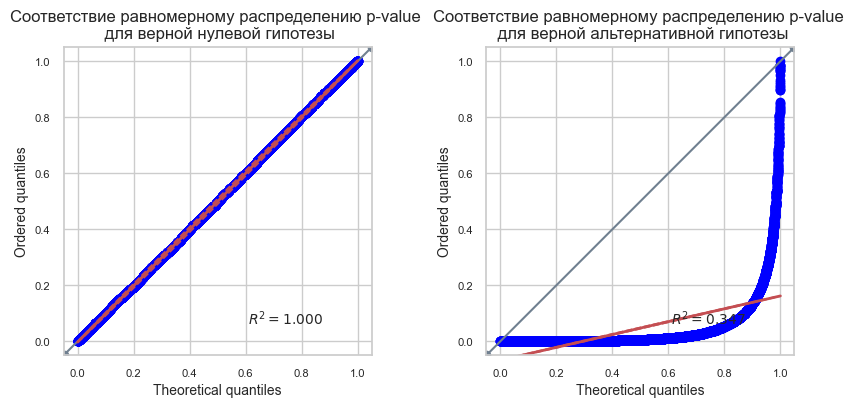

In [64]:
# проверка контролируемости ошибок I и II рода для данной величины MDE

min_mde = np.min([compute_mde, obs_mde])
iterations = 1000
AA_pvals = []
AB_pvals = []

for i in np.arange(10):
    
    counter_type1_err = 0
    counter_type2_err = 0

    for _ in np.arange(iterations):
        A1, A2, B = np.random.normal(mu, sigma, size), np.random.normal(mu, sigma, size), np.random.normal(mu, sigma, size)+min_mde
        AA_test = pg.ttest(A1, A2)
        AB_test = pg.ttest(A1, B)
        
        AA_pval = AA_test['p-val'].values[0]
        AB_pval = AB_test['p-val'].values[0]

        AA_pvals.append(AA_pval)
        AB_pvals.append(AB_pval)
        
        if AA_pval < alpha:
            counter_type1_err += 1
        if AB_test['p-val'].values[0] >= alpha:
            counter_type2_err += 1
    
    d_err_type1 = np.round(counter_type1_err / iterations * 100, 1)
    d_err_type2 = np.round(counter_type2_err / iterations * 100, 1)

    print(f'Итерация {i+1}: Доля ошибок I рода: {d_err_type1}%, II рода: {d_err_type2}%')

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0] = pg.qqplot(AA_pvals, dist='uniform', ax=axes[0])
axes[0].set(title = 'Соответствие равномерному распределению p-value \n для верной нулевой гипотезы')
axes[1] = pg.qqplot(AB_pvals, dist='uniform', ax=axes[1])
axes[1].set(title = 'Соответствие равномерному распределению p-value \n для верной альтернативной гипотезы')
fig.show()

### Взаимосвязь параметров эксперимента (MDE, объём выборки, дисперсия, баланс групп, ошибки I и II рода)

Для определения того, как реагирует та или иная характеристика на изменение остальных, проведём симуляции с использованием функции **tt_ind_solve_power**.

In [16]:
def tt_solve(find, iterate, iterate_values):
    lst_params = ['alpha', 'power', 'effect', 'sigma', 'size', 'ratio']
    lst_params.remove(find)
    lst_params.remove(iterate)

    param_values = []
    enters = []

    alpha = 0.05 if 'alpha' in lst_params else None
    power = 0.8 if 'power' in lst_params else None
    effect = 1.5 if 'effect' in lst_params else None
    sigma = 3 if 'sigma' in lst_params else None
    size = 50 if 'size' in lst_params else None
    ratio = 1 if 'ratio' in lst_params else None

    for j in iterate_values:
        alpha = j if iterate=='alpha' else alpha
        power = j if iterate=='power' else power
        effect = j if iterate=='effect' else effect
        sigma = j if iterate=='sigma' else sigma
        size = j if iterate=='size' else size
        ratio = j if iterate=='ratio' else ratio
        
        params = {'alpha': alpha, 'power': power, 'effect': effect, 'sigma': sigma, 'size': size, 'ratio': ratio}
        params = {key: params[key] for key in lst_params}
        
        try:
            es = effect/sigma
        except TypeError:
            es = None

        try:
            solve = tt_ind_solve_power(effect_size=es, nobs1=size, alpha=alpha, power=power, ratio=ratio, alternative='two-sided')
        except (ValueError, TypeError):
            solve = None
        if (find == 'ratio') and (solve != None) and (solve > 10000):
            solve = None
        if find == 'effect':
            solve = solve * sigma
        if find == 'sigma':
            solve = effect / solve
        param_values.append(solve)
        enters.append(params)

    return param_values, enters

In [17]:
find = ['alpha', 'power', 'effect', 'sigma', 'size', 'ratio']
index = pd.MultiIndex.from_product([find, find], names = ["find", "iterate"])
iterations = pd.DataFrame(index = index).reset_index().query('find != iterate')

iter_range = {'alpha': np.arange(0.01, 0.15, 0.01),
              'power': np.arange(0.7, 0.9, 0.01),
              'effect': np.arange(0.1, 3, 0.1),
              'sigma': np.arange(1, 20, 1),
              'size': np.arange(10, 500, 10),
              'ratio': np.arange(1, 20, 1)
             }

iterations['iter_range'] = iterations['iterate'].apply(lambda x: iter_range.get(x))
iterations['solution'], iterations['params'] = 0, 0

for row in iterations.itertuples():
    solution, params = tt_solve(find=row.find, iterate=row.iterate, iterate_values=row.iter_range)
    solution = [i[0] if isinstance(i, np.ndarray) else i for i in solution]
    iterations.loc[(iterations['find'] == row.find) & (iterations['iterate'] == row.iterate), 'solution'] = str(solution)
    iterations.loc[(iterations['find'] == row.find) & (iterations['iterate'] == row.iterate), 'params'] = str(params)

iterations['solution'] = iterations['solution'].apply(lambda x: [i.strip() for i in x[1:-1].replace('"',"").split(',')])

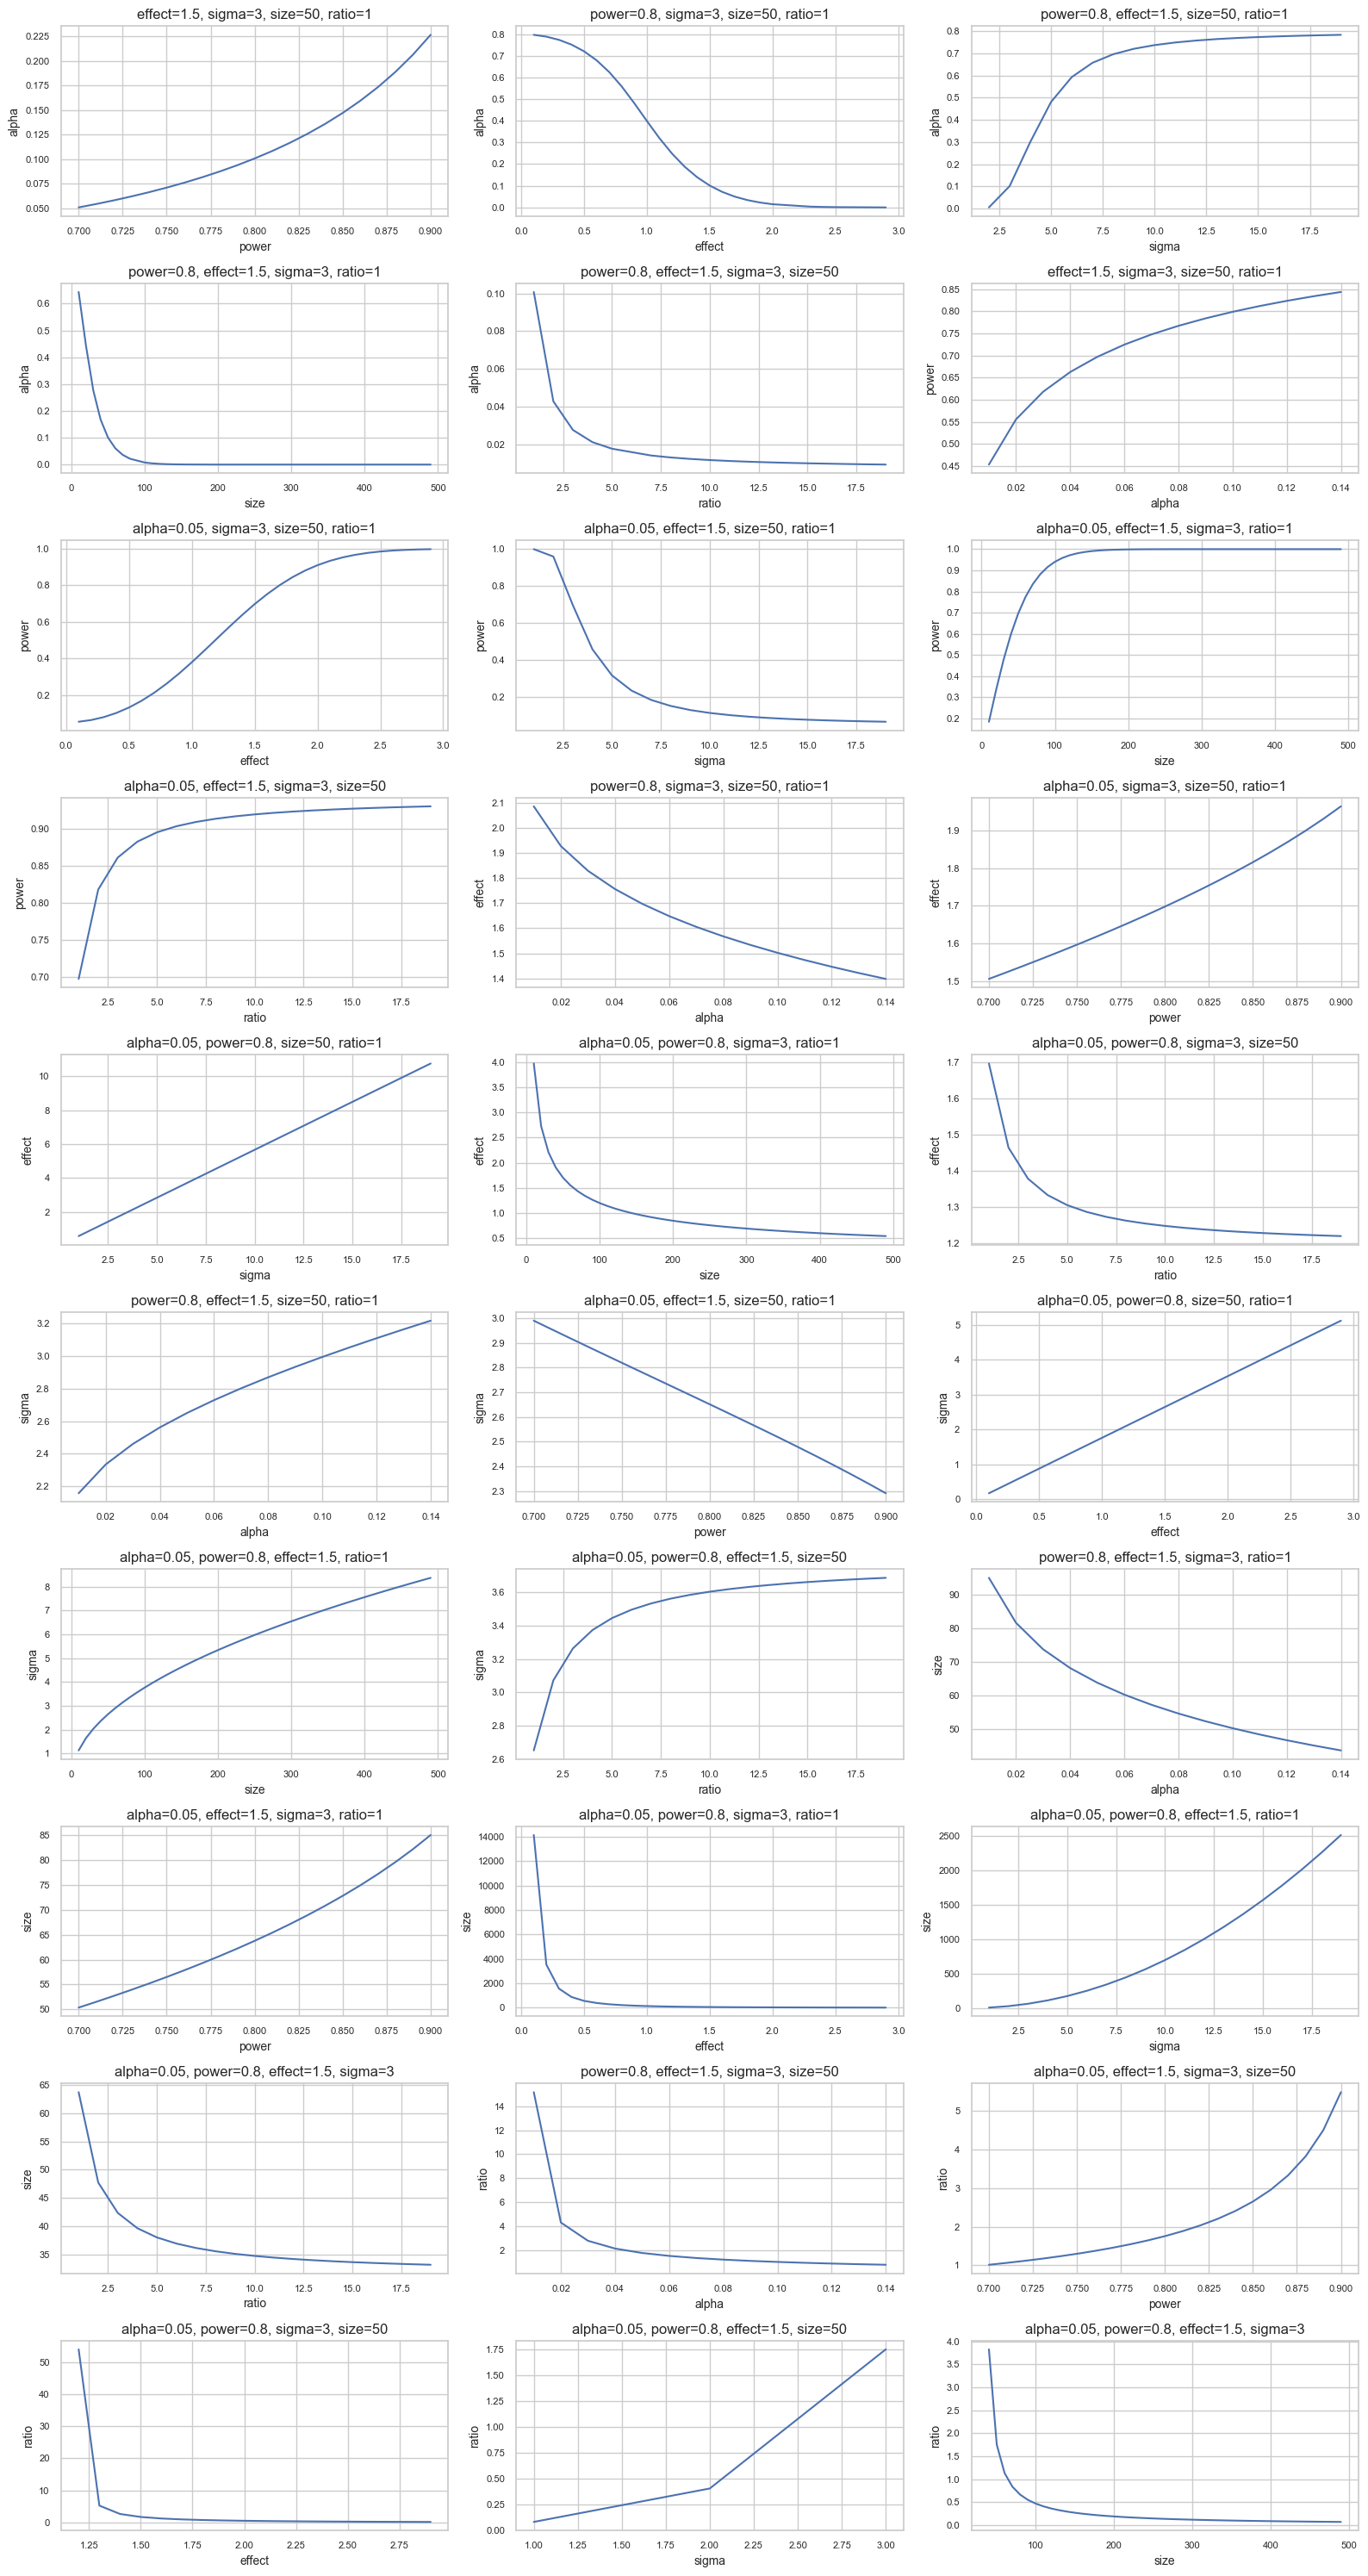

In [18]:
x = iterations.shape[0] // 3
y = iterations.shape[0] // x
if iterations.shape[0] - x*y > 0:
    x += 1

fig, axes = plt.subplots(x,y, figsize = (16,30))
xax = 0
yax = 0

counter = 0
for row in iterations.itertuples():
    if counter > 100:
        break
    else:
        start_data = row.params.split("}, {")
        param_find = row.find
        param_iterate = row.iterate
        df = pd.DataFrame({'range': row.iter_range, 'solution': row.solution, 'params': start_data})
        df = df.query('solution != "None"')
        df['solution'] = df['solution'].astype(float)
        df['params'] = df['params'].str.replace(r"(\[{)|(}\])|'", "", regex=True).str.replace(": ", "=")
        params_title = df['params'].unique()[0]
        counter += 1
    ax = sns.lineplot(x = df['range'], y = df['solution'], ax = axes[xax, yax], marker='')
    ax.set(ylabel = param_find, xlabel = param_iterate, title=params_title)
    yax += 1
    if yax > 2:
        yax = 0
        xax += 1

plt.tight_layout()
fig.show()

Исходя из полученных графиков, можно сделать выводы о следующей взаимосвязи факторов:

<table style="border: 1px solid rgb(0, 0, 0);">
  <tbody>
    <tr>
        <td align="center" rowspan="2" style="border: 1px solid rgb(0, 0, 0);">Влияющий фактор</td>
        <td align="center" colspan="2">Результат</td>
    </tr>
    <tr>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$\alpha$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$\beta$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$\Delta$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$\sigma$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$n$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$n_2 / n_1$</td>
    </tr>
    <tr>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$\alpha$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">-</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↑</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
    </tr>
    <tr>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$\beta$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">-</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↑</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
    </tr>
    <tr>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$\Delta$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">-</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↑</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center"style="border: 1px solid rgb(0, 0, 0);">↓</td>
    </tr>
    <tr>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$\sigma$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↑</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">-</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
    </tr>
    <tr>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$n$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↑</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">-</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
    </tr>
    <tr>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">$n_2 / n_1$</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↑</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">↓</td>
      <td align="center" style="border: 1px solid rgb(0, 0, 0);">-</td>
    </tr>
  </tbody>
</table>

Когда размер эффекта увеличивается, это снижает величину ошибки I и II рода и требует меньший объём выборки. 

Однако реальный эффект может не совпадать с ожидаемым. 

Если реальный эффект оказывается ниже ожидаемого, то следует ожидать увеличения вероятностей ошибок I и II рода. Чтобы избежать такой ситуации, необходимо заранее собирать выборку большего размера, если позволяет ситуация.

## Оценка доверительного интервала

### Влияние размера выборки и баланса групп на величину доверительного интервала

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 120.12it/s]


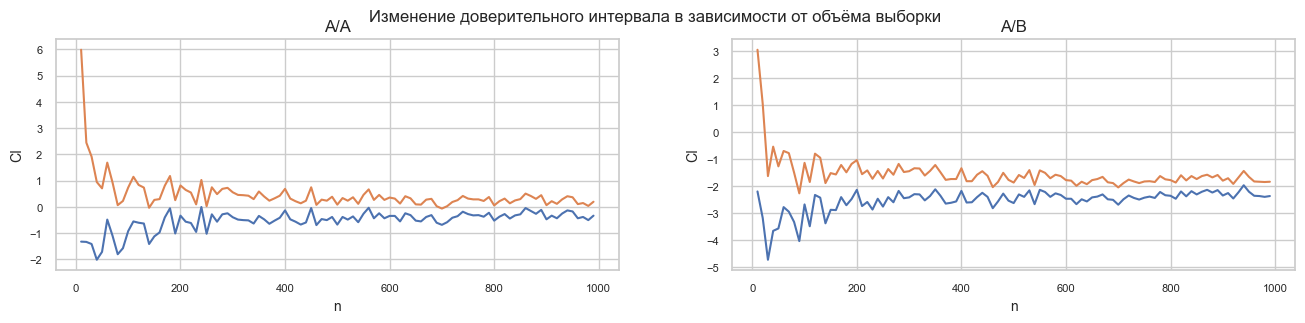

In [62]:
# влияние размера выборки

effect = 2
mu = 1.5
sigma = 3
size = 10
iterations = 100

sizes = np.arange(size, size*100, size)
AA_lb, AA_rb, AB_lb, AB_rb = [], [], [], []

for size in tqdm(sizes):
    A1, A2, B = np.random.normal(mu, sigma, size), np.random.normal(mu, sigma, size), np.random.normal(mu, sigma, size)+effect

    AA_test = pg.ttest(A1, A2)
    AB_test = pg.ttest(A1, B)

    AA_left_border, AA_right_border = AA_test['CI95%'][0][0], AA_test['CI95%'][0][1]
    AB_left_border, AB_right_border = AB_test['CI95%'][0][0], AB_test['CI95%'][0][1]

    AA_lb.append(AA_left_border), AA_rb.append(AA_right_border)
    AB_lb.append(AB_left_border), AB_rb.append(AB_right_border)

fig, axes = plt.subplots(1,2,figsize=(16,3))

axes[0].plot(sizes, AA_lb, marker='')
axes[0].plot(sizes, AA_rb, marker='')
axes[0].set(xlabel = 'n', ylabel='CI', title='A/A')

axes[1].plot(sizes, AB_lb, marker='')
axes[1].plot(sizes, AB_rb, marker='')
axes[1].set(xlabel = 'n', ylabel='CI', title='A/B')
fig.tight_layout()
fig.suptitle('Изменение доверительного интервала в зависимости от объёма выборки', y=1.05)
fig.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 123.44it/s]


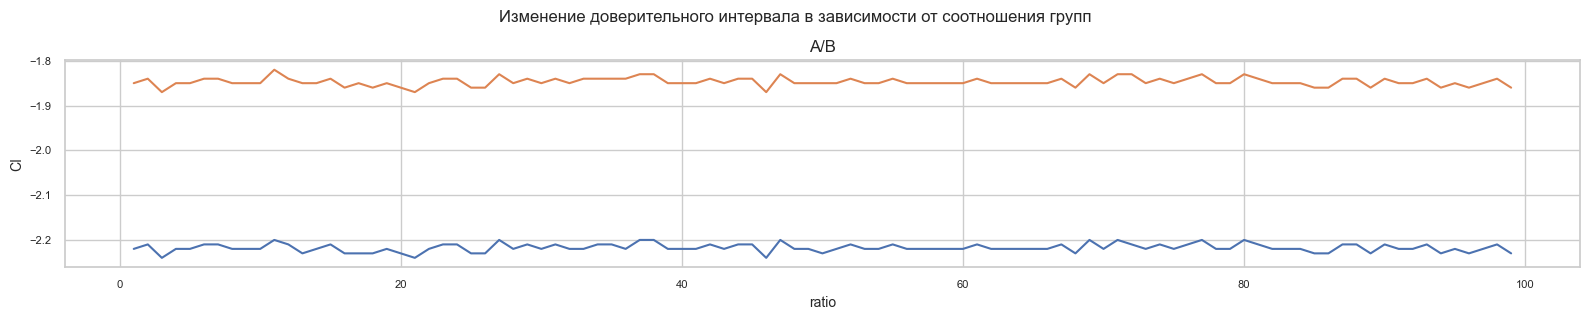

In [79]:
# влияние баланса групп

effect = 2
mu = 1.5
sigma = 3
size_total = 1000
iterations = 100

ratio = np.arange(1, 100)
AB_lb, AB_rb = [], []

for r in tqdm(ratio):
    A = np.random.normal(mu, sigma, (size_total * r / 100).astype(int))
    B = np.random.normal(mu, sigma, (size_total * (100-r / 100)).astype(int))+effect
    AB_test = pg.ttest(A1, B)

    AB_left_border, AB_right_border = AB_test['CI95%'][0][0], AB_test['CI95%'][0][1]

    AB_lb.append(AB_left_border), AB_rb.append(AB_right_border)

fig, axes = plt.subplots(1,1,figsize=(16,3))

axes.plot(ratio, AB_lb, marker='')
axes.plot(ratio, AB_rb, marker='')
axes.set(xlabel = 'ratio', ylabel='CI', title='A/B')

fig.tight_layout()
fig.suptitle('Изменение доверительного интервала в зависимости от соотношения групп', y=1.05)
fig.show()

Для сокращения доверительного интервала необходимо увеличивать размеры выборки. При этом соотношение между группами не влияет на величину доверительного интервала. Увеличение дисбаланса групп снижает вероятность ошибки как первого, так и второго рода и требует меньший объём выборки, но при этом сокращается и размер эффекта, который может быть достоверно обнаружен. 

### Виды bootstrap-доверительных интервалов

При использовании метода **bootstrap** доверительные интервалы для полученной оценки могут быть вычислены тремя способами:
* "стандартный" (нормальный)
* процентильный (Эфронов)
* центральный (Холла)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2919.77it/s]


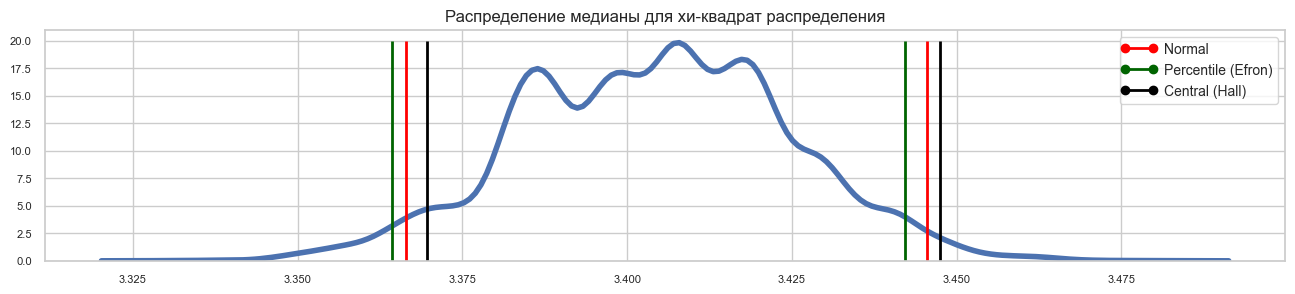

In [51]:
alpha = 0.05
size = 10000
sample = np.random.chisquare(2, size)+2
median_sample = np.median(sample)

iterations = 10000
medians = []
diff_medians = []
for _ in tqdm(range(iterations)):
    boot_sample = np.random.choice(sample, size=size)
    boot_median = np.median(boot_sample)
    medians.append(boot_median)
    diff_medians.append(boot_median - median_sample)

# нормальный доверительный интервал

norm_median_lower = median_sample - stats.norm.ppf(1 - alpha / 2) * np.std(medians)
norm_median_upper = median_sample + stats.norm.ppf(1 - alpha / 2) * np.std(medians)

# процентильный доверительный интервал

perc_median_lower = np.quantile(medians, alpha/2)
perc_median_upper = np.quantile(medians, 1-alpha/2)

# центральный доверительный интервал

cent_median_lower = median_sample - np.quantile(diff_medians, 1-alpha/2)
cent_median_upper = median_sample - np.quantile(diff_medians, alpha/2)

plt.figure(figsize=(16,3))
sns.kdeplot(medians, marker='', lw=4).set(title = 'Распределение медианы для хи-квадрат распределения', ylabel='')
plt.vlines((norm_median_lower, norm_median_upper), ymin=0, ymax=20, color='red', lw=2, label='Normal')
plt.vlines((perc_median_lower, perc_median_upper), ymin=0, ymax=20, color='darkgreen', lw=2, label='Percentile (Efron)')
plt.vlines((cent_median_lower, cent_median_upper), ymin=0, ymax=20, color='black', lw=2, label='Central (Hall)')
plt.legend()
plt.show()

## Стратификация

### Разложение общей дисперсии при стратификации

Если выборку можно разделить на несколько групп, то и общую дисперсию метрики, вычисляемой по общей выборке, можно разложить на несколько частей:
* **внутригрупповую** - определяется дисперсией в каждой из групп (более корректно её называть средней из внутригрупповых).
* **межгрупповую** - не связана с делением на группы.

При этом если будет введена иерархия групп (когда внутри каждой группы будет производиться разделение на новые группы), то и дисперсия для каждой из групп также будет разделяться на эти компоненты. 

В базовом варианте при А/В-тестах имеется только один уровень иерархии - разделение выборки на группы А и В. 

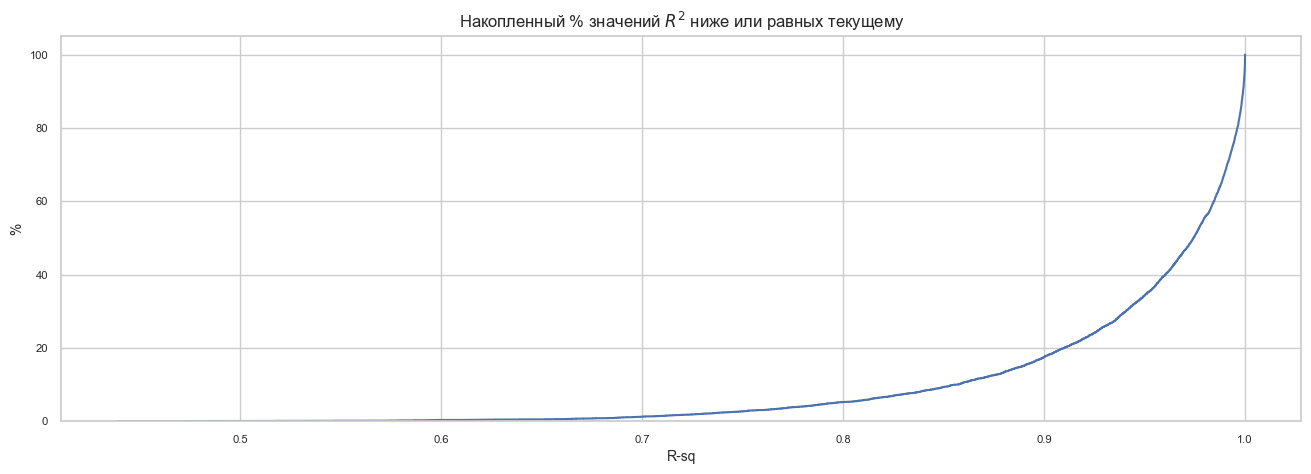

In [141]:
# один уровень иерархии групп, равные распределения и выборки

size = 10
mu = 5
sigma = 2

R_list = []
for _ in range(5000):
    df1 = pd.DataFrame({'group': 'A', 'metric': np.random.normal(mu, sigma, size)})
    df2 = pd.DataFrame({'group': 'B', 'metric': np.random.normal(mu, sigma, size)})
    df = pd.concat([df1, df2]).reset_index(drop=True)
    gr_metric = df.groupby('group', as_index = False) \
                  .agg(AvgGroup = ('metric', 'mean'), 
                       VarGroup = ('metric', 'var'),
                       Cnt = ('metric', 'count')) \
                  .assign(AvgTotal = lambda x: df['metric'].mean(),
                          VarGroup = lambda x: x['VarGroup'] * (x['Cnt'] - 1) / x['Cnt'],
                          AvgDiff = lambda x: x['AvgGroup'] - x['AvgTotal']
                         )
    
    disp_wth = np.mean(gr_metric['AvgDiff']**2, axis=0)
    disp_btw = np.mean(gr_metric['VarGroup'], axis=0)
    R_sq = disp_btw / (disp_wth + disp_btw)
    R_list.append(R_sq)

plt.figure(figsize = (16,5))
ax = sns.ecdfplot(R_list,stat='percent',marker='')
ax.set(ylabel='%', xlabel='R-sq', title='Накопленный % значений ${R^2}$ ниже или равных текущему')
plt.show()

Когда параметры распределений одинаковы, то большая часть часть вариации объясняется внутригрупповой дисперсией. 
Если менять соотношение средних, дисперсий или объёма выборок, то картина будет меняться.

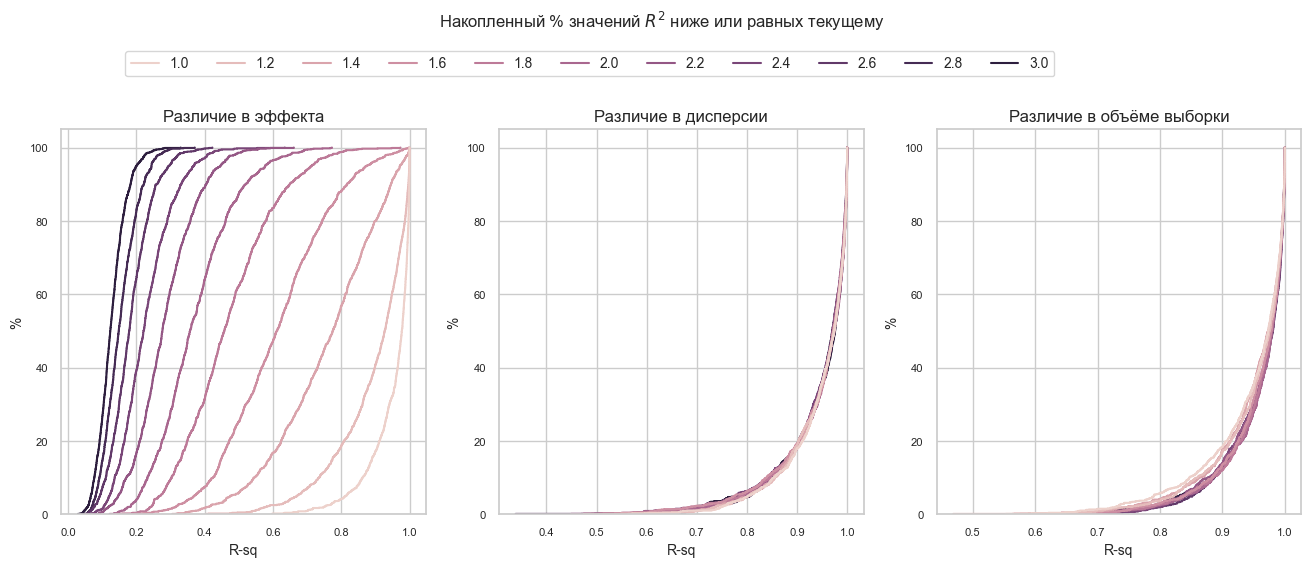

In [225]:
# один уровень иерархии групп, разные распределения и выборки

size = 10
mu = 5
sigma = 2

ratio = np.arange(1, 3.1, 0.2).round(1)
R_df = pd.DataFrame()

for r in ratio:
    R_list_mu = []
    R_list_sigma = []
    R_list_n = []
    for _ in range(1000):
        df1 = pd.DataFrame({'group': 'A', 'metric': np.random.normal(mu, sigma, size)})
        
        df2_mu = pd.DataFrame({'group': 'B', 'metric': np.random.normal(mu*r, sigma, size)})
        df2_sigma = pd.DataFrame({'group': 'B', 'metric': np.random.normal(mu, sigma*r, size)})
        df2_n = pd.DataFrame({'group': 'B', 'metric': np.random.normal(mu, sigma, int(size*r))})
        
        df_mu = pd.concat([df1, df2_mu]).reset_index(drop=True)
        df_sigma = pd.concat([df1, df2_sigma]).reset_index(drop=True)
        df_n = pd.concat([df1, df2_n]).reset_index(drop=True)
        
        gr_mu = df_mu.groupby('group', as_index = False) \
                      .agg(AvgGroup = ('metric', 'mean'), 
                           VarGroup = ('metric', 'var'),
                           Cnt = ('metric', 'count')) \
                      .assign(AvgTotal = lambda x: df_mu['metric'].mean(),
                              VarGroup = lambda x: x['VarGroup'] * (x['Cnt'] - 1) / x['Cnt'],
                              AvgDiff = lambda x: x['AvgGroup'] - x['AvgTotal']
                             )
        gr_sigma = df_sigma.groupby('group', as_index = False) \
                      .agg(AvgGroup = ('metric', 'mean'), 
                           VarGroup = ('metric', 'var'),
                           Cnt = ('metric', 'count')) \
                      .assign(AvgTotal = lambda x: df_sigma['metric'].mean(),
                              VarGroup = lambda x: x['VarGroup'] * (x['Cnt'] - 1) / x['Cnt'],
                              AvgDiff = lambda x: x['AvgGroup'] - x['AvgTotal']
                             )
        gr_n = df_n.groupby('group', as_index = False) \
                      .agg(AvgGroup = ('metric', 'mean'), 
                           VarGroup = ('metric', 'var'),
                           Cnt = ('metric', 'count')) \
                      .assign(AvgTotal = lambda x: df_n['metric'].mean(),
                              VarGroup = lambda x: x['VarGroup'] * (x['Cnt'] - 1) / x['Cnt'],
                              AvgDiff = lambda x: x['AvgGroup'] - x['AvgTotal']
                             )
        
        disp_wth_mu = np.mean(gr_mu['AvgDiff']**2, axis=0)
        disp_wth_sigma = np.mean(gr_sigma['AvgDiff']**2, axis=0)
        disp_wth_n = np.mean(gr_n['AvgDiff']**2, axis=0)
        
        disp_btw_mu = np.mean(gr_mu['VarGroup'], axis=0)
        disp_btw_sigma = np.mean(gr_sigma['VarGroup'], axis=0)
        disp_btw_n = np.mean(gr_n['VarGroup'], axis=0)
        
        R_sq_mu = disp_btw_mu / (disp_wth_mu + disp_btw_mu)
        R_sq_sigma = disp_btw_sigma / (disp_wth_sigma + disp_btw_sigma)
        R_sq_n = disp_btw_n / (disp_wth_n + disp_btw_n)
        
        R_list_mu.append(R_sq_mu)
        R_list_sigma.append(R_sq_sigma)
        R_list_n.append(R_sq_n)

    R_iter = pd.DataFrame() 
    R_iter['mu'] = R_list_mu
    R_iter['sigma'] = R_list_sigma
    R_iter['n'] = R_list_n
    R_iter['r'] = r
    R_df = pd.concat([R_df, R_iter])
    
fig, axes = plt.subplots(1, 3, figsize = (16,5))

ax1 = sns.ecdfplot(data = R_df, x='mu', hue='r', stat='percent', marker='', ax = axes[0])
ax1.set(ylabel='%', xlabel='R-sq', title='Различие в эффекта')
leg = ax1.get_legend()
ax1.get_legend().remove()

ax2 = sns.ecdfplot(data = R_df, x='sigma', hue='r', stat='percent', marker='', ax = axes[1])
ax2.set(ylabel='%', xlabel='R-sq', title='Различие в дисперсии')
ax2.get_legend().remove()

ax3 = sns.ecdfplot(data = R_df, x='n', hue='r', stat='percent', marker='', ax = axes[2])
ax3.set(ylabel='%', xlabel='R-sq', title='Различие в объёме выборки')
ax3.get_legend().remove()

fig.legend(handles = leg.legend_handles, labels = list(ratio), ncols = 11, bbox_to_anchor = (0.75,1.05))
fig.suptitle('Накопленный % значений ${R^2}$ ниже или равных текущему', y = 1.12)
fig.show()

По графикам выше видно, что чем сильнее расхождение в эффекте, тем меньше общая дисперсия объясняется внутригрупповой. 

При этом разница в дисперсиях, когда эффект в группах одинаковых - не влияет долю внутригрупповой дисперсии, объём выборки также влияет незначительно.

### Два уровня иерархии групп

В А/В-тестировании стратификация добавляет ещё один или несколько уровней групповой иерархии - когда внутри каждой группы (тестовой и контрольной) производится разделение по другим признакам. Рассмотрим изменения при добавлении второго уровня из двух признаков. 

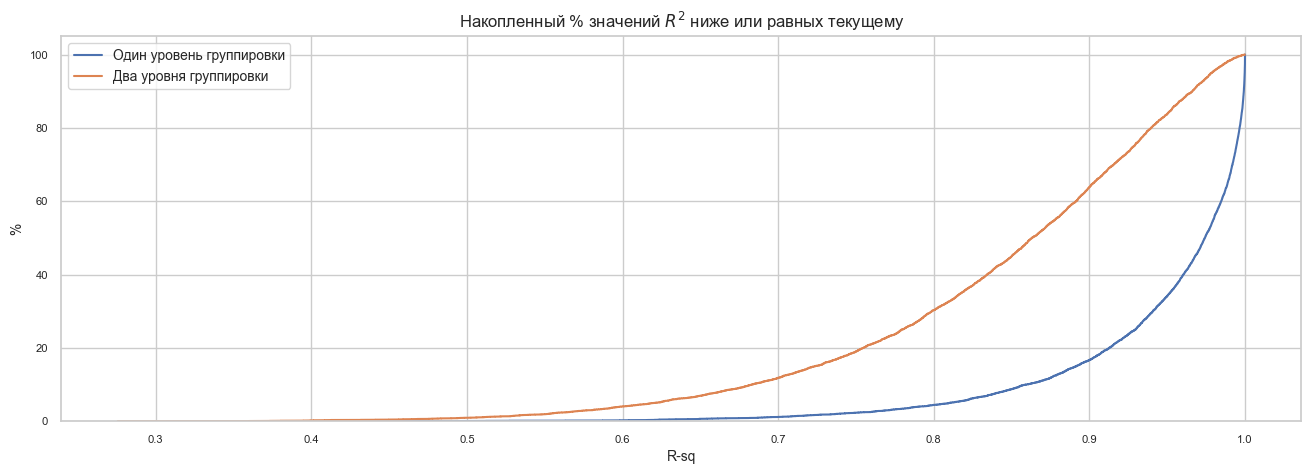

In [60]:
size = 10
mu = 5
sigma = 2

R_list_L1 = []
R_list_L2 = []
for _ in range(5000):
    df1 = pd.DataFrame({'group': 'A', 'strat': np.random.uniform(size=size).round(0).astype(int), 'metric': np.random.normal(mu, sigma, size)})
    df2 = pd.DataFrame({'group': 'B', 'strat': np.random.uniform(size=size).round(0).astype(int), 'metric': np.random.normal(mu, sigma, size)})
    df = pd.concat([df1, df2]).reset_index(drop=True)

    gr_lvl1 = df.groupby('group', as_index = False) \
              .agg(AvgL1 = ('metric', 'mean'), 
                   VarL1 = ('metric', 'var'),
                   CntL1 = ('metric', 'count')) \
              .assign(AvgTotal = lambda x: df['metric'].mean(),
                      VarL1 = lambda x: x['VarL1'] * (x['CntL1'] - 1) / x['CntL1'],
                      AvgDiffL1 = lambda x: x['AvgL1'] - x['AvgTotal']
                     )

    gr_lvl2 = df.groupby(['group', 'strat'], as_index = False) \
                  .agg(AvgL2 = ('metric', 'mean'), 
                       VarL2 = ('metric', 'var'),
                       CntL2 = ('metric', 'count')) \
                  .merge(gr_lvl1[['group', 'AvgL1', 'VarL1']], on = 'group') \
                  .assign(VarL2 = lambda x: x['VarL2'] * (x['CntL2'] - 1) / x['CntL2'],
                          VarL2_x_CntL2 = lambda x: x['VarL2'] * x['CntL2']
                         )
    
    disp_wth_lvl1 = np.mean(gr_lvl1['AvgDiffL1']**2, axis=0)
    disp_btw_lvl1 = np.mean(gr_lvl1['VarL1'], axis=0)
    R_sq = disp_btw_lvl1 / (disp_wth_lvl1 + disp_btw_lvl1)
    
    gr2_lvl2 = gr_lvl2.groupby('group') \
                        .agg(VarL1 = ('VarL1', 'mean'), 
                             SumVarL2 = ('VarL2_x_CntL2', 'sum'), 
                             CntL2 = ('CntL2', 'sum')
                            ) \
                        .assign(VarBtwL2 = lambda x: x['SumVarL2'] / x['CntL2'],
                                VarWthL2 = lambda x: x['VarL1'] - x['VarBtwL2']
                               )
    
    disp_wth_lvl2 = gr2_lvl2['VarWthL2'].sum() / gr2_lvl2['VarWthL2'].count()
    disp_btw_lvl2 = gr2_lvl2['VarBtwL2'].sum() / gr2_lvl2['VarBtwL2'].count()
    R_sq_lvl2 = disp_btw_lvl2 / (disp_wth_lvl1 + disp_btw_lvl1)
    Pct_wth = disp_wth_lvl2 / (disp_wth_lvl1 + disp_btw_lvl1)
    
    R_list_L1.append(R_sq)
    R_list_L2.append(R_sq_lvl2)

plt.figure(figsize = (16,5))
ax = sns.ecdfplot(R_list_L1,stat='percent',marker='')
ax = sns.ecdfplot(R_list_L2,stat='percent',marker='')
ax.set(ylabel='%', xlabel='R-sq', title='Накопленный % значений ${R^2}$ ниже или равных текущему')
ax.legend(labels = ['Один уровень группировки', 'Два уровня группировки'])
plt.show()

Таким образом, добавление даже случайного, но равномерного распределения по группам на втором уровне иерархии к данным, имеющим одинаковое распределение - приводит к тому, что большая доля общей дисперсии объясняется внутригрупповой вариацией. 

### Стратифицированное среднее

Выше было показано, что увеличение иерархии групп позволяет перераспределить структуру дисперсии между внутригрупповой и межгрупповой, "отдав" большую долю внутригрупповой даже в тех случаях, когда распределения групп одинаковы. 

Если в A/B-тестах сравниваются метрики средних значений, то это свойство позволяет переходить к другой метрике среднего - стратифицированному среднему, которое сохраняет свойство несмещённости, но будет иметь меньшую дисперсию по сравнению с исходным средним, т.к. будет включать только внутригрупповую дисперсию. При этом необходимо, чтобы между стратами были отличия, в противном случае стратификация не даст эффекта. 

При невозможности стратифицированного сэмплирования может быть использован подход с пост-стратификацией:
* собирается выборка методом случайного сэмплирования;
* рассчитываются средние значения метрики в каждой страте;
* далее рассчитывается взвешенная средняя этих средних, исходя из реальной доли страт в генеральной совокупности.

В таком случае результаты, полученные таким подходом, близки результатам обычной стратификации. 

In [33]:
g_size = 100000
sample = 1000

mu = 5
sigma = 1
eff = 1
str_diff = 2
perc_grA, perc_grB = 0.5, 0.5
perc_str0, perc_str1 = 0.6, 0.4

g0 = np.random.normal(mu, sigma, int(perc_str0 * g_size))
g1 = np.random.normal(mu, sigma, int(perc_str1 * g_size))

g_df0 = pd.DataFrame({'strat': 0, 'metric': g0})
g_df1 = pd.DataFrame({'strat': 1, 'metric': g1})
g_df = pd.concat([g_df0, g_df1]).reset_index(drop = True)
g_df['metric'] = np.where(g_df['strat'] == 1, g_df['metric'] + str_diff, g_df['metric'])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.61it/s]


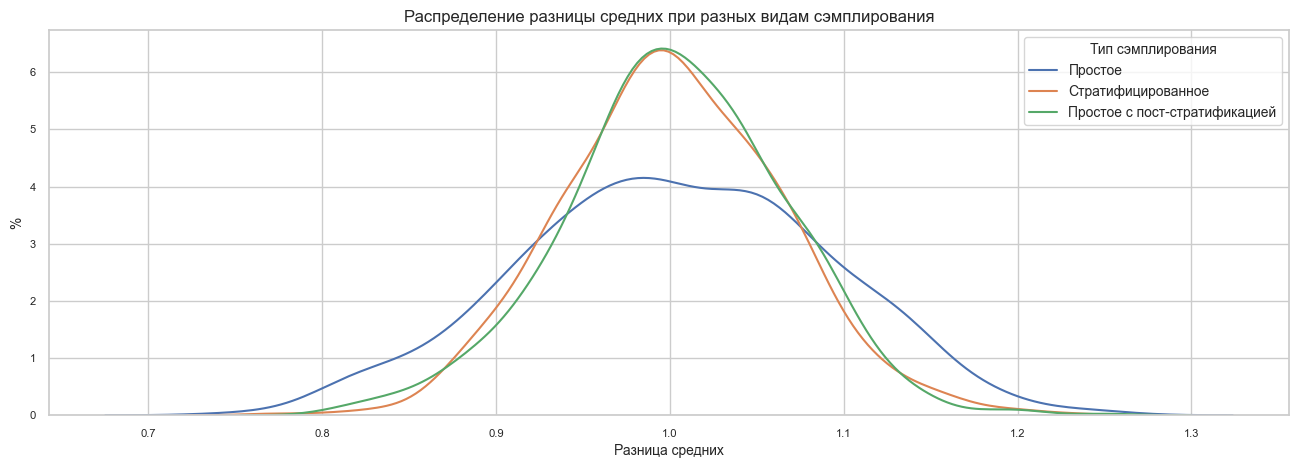

In [35]:
SRS_mean_diff = []
STR_mean_diff = []
post_STR_mean_diff = []

for _ in tqdm(range(1000)):
    # простое случайное сэмплирование (SRS)
    SRS = g_df.loc[np.random.choice(g_df.index, sample)]
    SRS['group'] = ['A']*int(perc_grA * sample) + ['B']*int(perc_grB * sample)
    SRS['metric'] = np.where(SRS['group'] == "B", SRS['metric'] + eff, SRS['metric'])
    mean_diff = SRS.query('group == "B"')['metric'].mean() - SRS.query('group == "A"')['metric'].mean()
    SRS_mean_diff.append(mean_diff)

    # пост-стратификация
    diff_str0 = SRS.query('strat == 0 and group == "B"')['metric'].mean() - SRS.query('strat == 0 and group == "A"')['metric'].mean()
    diff_str1 = SRS.query('strat == 1 and group == "B"')['metric'].mean() - SRS.query('strat == 1 and group == "A"')['metric'].mean()
    mean_diff = diff_str0 * perc_str0 + diff_str1 * perc_str1
    post_STR_mean_diff.append(mean_diff)

    # стратифицированное сэмплирование (STR)
    str0_sample = g_df.query('strat == 0').sample(int(sample * perc_str0))
    str1_sample = g_df.query('strat == 1').sample(int(sample * perc_str1))
    str0_sample['group'] = ['A']*int(perc_grA * len(str0_sample)) + ['B']*int(perc_grB * len(str0_sample))
    str1_sample['group'] = ['A']*int(perc_grA * len(str1_sample)) + ['B']*int(perc_grB * len(str1_sample))
    STR = pd.concat([str0_sample, str1_sample])
    STR['metric'] = np.where(STR['group'] == "B", STR['metric'] + eff, STR['metric'])
    diff_str0 = STR.query('strat == 0 and group == "B"')['metric'].mean() - STR.query('strat == 0 and group == "A"')['metric'].mean()
    diff_str1 = STR.query('strat == 1 and group == "B"')['metric'].mean() - STR.query('strat == 1 and group == "A"')['metric'].mean()
    mean_diff = diff_str0 * perc_str0 + diff_str1 * perc_str1
    STR_mean_diff.append(mean_diff)

plt.figure(figsize = (16, 5))
ax = sns.kdeplot(SRS_mean_diff, marker='')
ax = sns.kdeplot(STR_mean_diff, marker='')
ax = sns.kdeplot(post_STR_mean_diff, marker='')
ax.set(xlabel = 'Разница средних', ylabel='%', title='Распределение разницы средних при разных видам сэмплирования')
ax.legend(labels=['Простое','Стратифицированное','Простое с пост-стратификацией'], title='Тип сэмплирования')
plt.show()

Рассмотрим, при каких отличиях между стратами будет наблюдаться эффект сокращения дисперсии при стратификации. 

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [03:03<00:00,  1.85s/it]


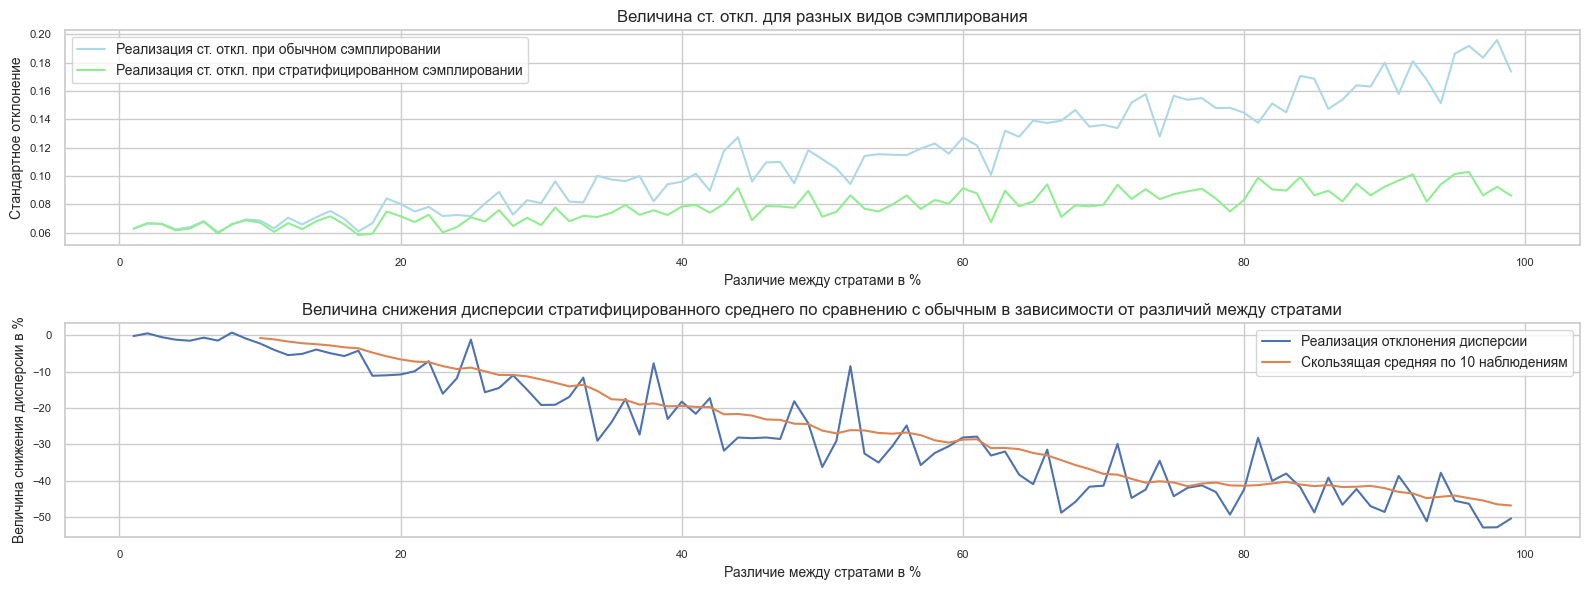

In [78]:
g_size, sample = 100000, 1000
mu, sigma, eff = 5, 1, 1
perc_grA, perc_grB = 0.5, 0.5
perc_str0, perc_str1 = 0.6, 0.4

g_df0 = pd.DataFrame({'strat': 0, 'metric': np.random.normal(mu, sigma, int(perc_str0 * g_size))})
g_df1 = pd.DataFrame({'strat': 1, 'metric': np.random.normal(mu, sigma, int(perc_str1 * g_size))})
g_df = pd.concat([g_df0, g_df1]).reset_index(drop = True)

str_diff = np.arange(0.01, 1, 0.01)

std_SRS = []
std_STR = []

for diff in tqdm(str_diff):
    g_df_iter = g_df.copy()
    g_df_iter['metric'] = np.where(g_df_iter['strat'] == 1, g_df_iter['metric'] * (1+diff), g_df_iter['metric'])
    
    SRS_mean_diff = []
    STR_mean_diff = []
    
    for _ in range(100):
        # простое случайное сэмплирование (SRS)
        SRS = g_df_iter.loc[np.random.choice(g_df.index, sample)]
        SRS['group'] = ['A']*int(perc_grA * sample) + ['B']*int(perc_grB * sample)
        SRS['metric'] = np.where(SRS['group'] == "B", SRS['metric'] + eff, SRS['metric'])
        mean_diff = SRS.query('group == "B"')['metric'].mean() - SRS.query('group == "A"')['metric'].mean()
        SRS_mean_diff.append(mean_diff)
    
        # стратифицированное сэмплирование (STR)
        str0_sample = g_df_iter.query('strat == 0').sample(int(sample * perc_str0))
        str1_sample = g_df_iter.query('strat == 1').sample(int(sample * perc_str1))
        str0_sample['group'] = ['A']*int(perc_grA * len(str0_sample)) + ['B']*int(perc_grB * len(str0_sample))
        str1_sample['group'] = ['A']*int(perc_grA * len(str1_sample)) + ['B']*int(perc_grB * len(str1_sample))
        STR = pd.concat([str0_sample, str1_sample])
        STR['metric'] = np.where(STR['group'] == "B", STR['metric'] + eff, STR['metric'])
        diff_str0 = SRS.query('strat == 0 and group == "B"')['metric'].mean() - SRS.query('strat == 0 and group == "A"')['metric'].mean()
        diff_str1 = SRS.query('strat == 1 and group == "B"')['metric'].mean() - SRS.query('strat == 1 and group == "A"')['metric'].mean()
        mean_diff = diff_str0 * perc_str0 + diff_str1 * perc_str1
        STR_mean_diff.append(mean_diff)

    std_STR.append(np.std(STR_mean_diff, ddof=0)) 
    std_SRS.append(np.std(SRS_mean_diff, ddof=0))

str_diff = str_diff * 100
pct_diff = (np.array(std_STR) / np.array(std_SRS) - 1) * 100

fig, axes = plt.subplots(2, 1, figsize = (16,6))
axes[0].plot(str_diff, std_SRS, marker='', color = 'lightblue')
axes[0].plot(str_diff, std_STR, marker='', color = 'lightgreen')
axes[0].set(title='Величина ст. откл. для разных видов сэмплирования',
            xlabel='Различие между стратами в %', ylabel='Стандартное отклонение'
           )
axes[0].legend(['Реализация ст. откл. при обычном сэмплировании', 'Реализация ст. откл. при стратифицированном сэмплировании'])
axes[1].plot(str_diff, pct_diff, marker = '')
axes[1].plot(str_diff, pd.Series(pct_diff).rolling(10).mean(), marker='')
axes[1].set(title='Величина снижения дисперсии стратифицированного среднего по сравнению с обычным в зависимости от различий между стратами',
            xlabel='Различие между стратами в %', ylabel='Величина снижения дисперсии в %'
           )
axes[1].legend(['Реализация отклонения дисперсии', 'Скользящая средняя по 10 наблюдениям'])
fig.tight_layout()
fig.show()

Увеличение различий между стратами влечёт и рост дисперсии среднего значения. 

Но при использовании стратификации, дисперсия стратифицированного среднего растёт гораздо медленнее. 
Таким образом, при малых различиях между стратами использование стратификации может не дать эффекта.

На примере выше, заметный эффект сокращения дисперсии начал наблюдаться при разнице в эффекте между стратами более 10%. 

Также снижение дисперсии достигается и за счёт увеличения объёма выборки.

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [01:24<00:00,  1.72s/it]


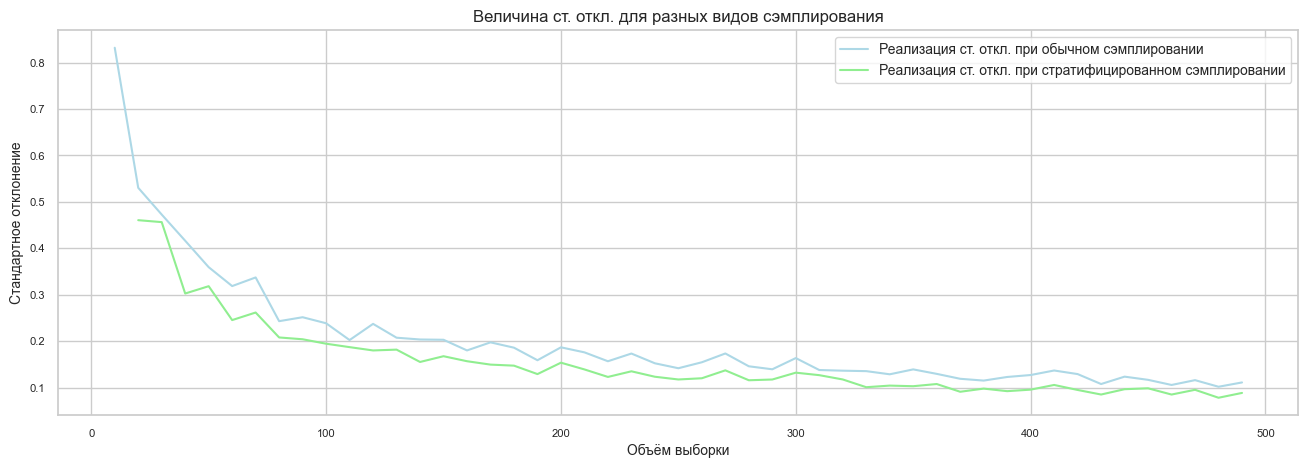

In [81]:
g_size = 100000
mu, sigma, eff, str_diff = 5, 1, 1, 1.5
perc_grA, perc_grB = 0.5, 0.5
perc_str0, perc_str1 = 0.6, 0.4

g_df0 = pd.DataFrame({'strat': 0, 'metric': np.random.normal(mu, sigma, int(perc_str0 * g_size))})
g_df1 = pd.DataFrame({'strat': 1, 'metric': np.random.normal(mu, sigma, int(perc_str1 * g_size))})
g_df = pd.concat([g_df0, g_df1]).reset_index(drop = True)

samples = np.arange(10, 500, 10)
std_SRS = []
std_STR = []

for sample in tqdm(samples):
    g_df_iter = g_df.copy()
    g_df_iter['metric'] = np.where(g_df_iter['strat'] == 1, g_df_iter['metric'] + str_diff, g_df_iter['metric'])
    
    SRS_mean_diff = []
    STR_mean_diff = []
    
    for _ in range(100):
        # простое случайное сэмплирование (SRS)
        SRS = g_df_iter.loc[np.random.choice(g_df.index, sample)]
        SRS['group'] = ['A']*int(perc_grA * sample) + ['B']*int(perc_grB * sample)
        SRS['metric'] = np.where(SRS['group'] == "B", SRS['metric'] + eff, SRS['metric'])
        mean_diff = SRS.query('group == "B"')['metric'].mean() - SRS.query('group == "A"')['metric'].mean()
        SRS_mean_diff.append(mean_diff)
    
        # стратифицированное сэмплирование (STR)
        str0_sample = g_df_iter.query('strat == 0').sample(int(sample * perc_str0))
        str1_sample = g_df_iter.query('strat == 1').sample(int(sample * perc_str1))
        str0_sample['group'] = ['A']*int(perc_grA * len(str0_sample)) + ['B']*int(perc_grB * len(str0_sample))
        str1_sample['group'] = ['A']*int(perc_grA * len(str1_sample)) + ['B']*int(perc_grB * len(str1_sample))
        STR = pd.concat([str0_sample, str1_sample])
        STR['metric'] = np.where(STR['group'] == "B", STR['metric'] + eff, STR['metric'])
        diff_str0 = SRS.query('strat == 0 and group == "B"')['metric'].mean() - SRS.query('strat == 0 and group == "A"')['metric'].mean()
        diff_str1 = SRS.query('strat == 1 and group == "B"')['metric'].mean() - SRS.query('strat == 1 and group == "A"')['metric'].mean()
        mean_diff = diff_str0 * perc_str0 + diff_str1 * perc_str1
        STR_mean_diff.append(mean_diff)

    std_STR.append(np.std(STR_mean_diff, ddof=0)) 
    std_SRS.append(np.std(SRS_mean_diff, ddof=0))

fig, axes = plt.subplots(1, 1, figsize = (16,5))
axes.plot(samples, std_SRS, marker='', color = 'lightblue')
axes.plot(samples, std_STR, marker='', color = 'lightgreen')
axes.set(title='Величина ст. откл. для разных видов сэмплирования',
            xlabel='Объём выборки', ylabel='Стандартное отклонение'
           )
axes.legend(['Реализация ст. откл. при обычном сэмплировании', 'Реализация ст. откл. при стратифицированном сэмплировании'])
fig.show()

Для малых выборок отклонения в дисперсии могут быть значительными для разных методов, но эти отклонения сокращаются с ростом выборки. 

Таким образом: при большой выборке и малой величине различий между стратами подход стратификации не будет давать существенного снижения в дисперсии при изменении целевой метрики с обычного на стратифицированное среднее. 

### Влияние стратификации на величину ошибок I и II рода

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 32.34it/s]


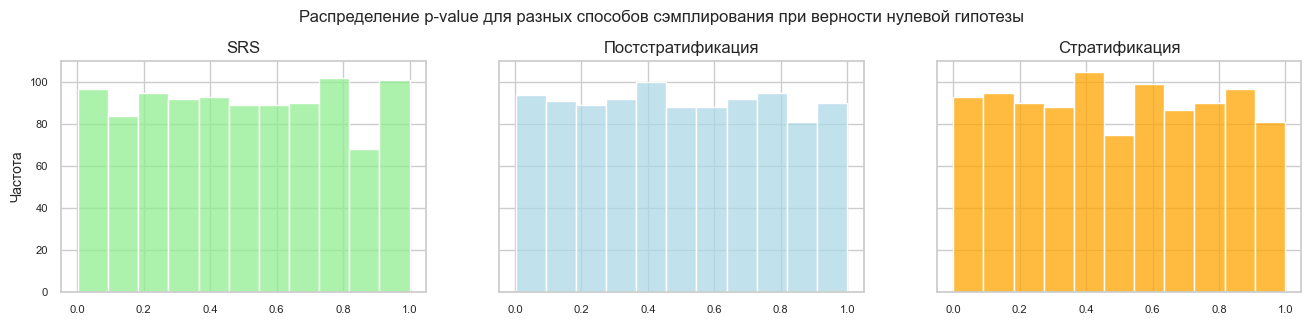

In [18]:
# оценка ошибки I рода

g_size, sample = 100000, 1000
mu, sigma, str_diff = 5, 1, 1.5
perc_grA, perc_grB = 0.5, 0.5
perc_str0, perc_str1 = 0.6, 0.4

g_df0 = pd.DataFrame({'strat': 0, 'metric': np.random.normal(mu, sigma, int(perc_str0 * g_size))})
g_df1 = pd.DataFrame({'strat': 1, 'metric': np.random.normal(mu, sigma, int(perc_str1 * g_size))})
g_df = pd.concat([g_df0, g_df1]).reset_index(drop = True)

SRS_pval = []
SRS_str_pval = []
STR_pval = []

for _ in tqdm(range(1000)):
    # простое случайное сэмплирование (SRS)
    SRS = g_df.loc[np.random.choice(g_df.index, sample)]
    SRS['group'] = ['A']*int(perc_grA * sample) + ['B']*int(perc_grB * sample)
    values_A = SRS.query('group == "A"')['metric'].values
    values_B = SRS.query('group == "B"')['metric'].values
    _, pvalue = stats.ttest_ind(values_A, values_B)
    SRS_pval.append(pvalue)

    # пост-стратификация
    values_0B = SRS.query('strat == 0 and group == "B"')['metric'].values
    values_0A = SRS.query('strat == 0 and group == "A"')['metric'].values
    values_1B = SRS.query('strat == 1 and group == "B"')['metric'].values
    values_1A = SRS.query('strat == 1 and group == "A"')['metric'].values
    
    mean_diff = (values_0B.mean() - values_0A.mean()) * perc_str0 + (values_1B.mean() - values_1A.mean()) * perc_str1
    var_B = values_0B.var(ddof = 0) * perc_str0 + values_1B.var(ddof = 0) * perc_str1
    var_A = values_0A.var(ddof = 0) * perc_str0 + values_1A.var(ddof = 0) * perc_str1
    var_diff = np.sqrt(var_A / len(SRS.query('group == "A"').values) + var_B / len(SRS.query('group == "B"').values))
    t_val = mean_diff / var_diff
    pvalue = (1 - stats.norm.cdf(np.abs(t_val))) * 2
    SRS_str_pval.append(pvalue)

    # стратифицированное сэмплирование (STR)
    str0_sample = g_df.query('strat == 0').sample(int(sample * perc_str0))
    str1_sample = g_df.query('strat == 1').sample(int(sample * perc_str1))
    str0_sample['group'] = ['A']*int(perc_grA * len(str0_sample)) + ['B']*int(perc_grB * len(str0_sample))
    str1_sample['group'] = ['A']*int(perc_grA * len(str1_sample)) + ['B']*int(perc_grB * len(str1_sample))
    STR = pd.concat([str0_sample, str1_sample])
    
    values_0B = STR.query('strat == 0 and group == "B"')['metric'].values
    values_0A = STR.query('strat == 0 and group == "A"')['metric'].values
    values_1B = STR.query('strat == 1 and group == "B"')['metric'].values
    values_1A = STR.query('strat == 1 and group == "A"')['metric'].values
    
    mean_diff = (values_0B.mean() - values_0A.mean()) * perc_str0 + (values_1B.mean() - values_1A.mean()) * perc_str1
    var_B = values_0B.var(ddof = 0) * perc_str0 + values_1B.var(ddof = 0) * perc_str1
    var_A = values_0A.var(ddof = 0) * perc_str0 + values_1A.var(ddof = 0) * perc_str1
    var_diff = np.sqrt(var_A / len(SRS.query('group == "A"').values) + var_B / len(SRS.query('group == "B"').values))
    t_val = mean_diff / var_diff
    pvalue = (1 - stats.norm.cdf(np.abs(t_val))) * 2
    STR_pval.append(pvalue)

fig, axes = plt.subplots(1,3, figsize = (16,3), sharey=True)
ax1 = sns.histplot(SRS_pval, ax = axes[0], color = 'lightgreen')
ax2 = sns.histplot(SRS_str_pval, ax = axes[1], color = 'lightblue')
ax3 = sns.histplot(STR_pval, ax = axes[2], color = 'orange')
ax1.set(ylabel = 'Частота', title = 'SRS')
ax2.set(title = 'Постстратификация')
ax3.set(title = 'Стратификация')
fig.suptitle('Распределение p-value для разных способов сэмплирования при верности нулевой гипотезы', y = 1.05)
fig.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.48it/s]


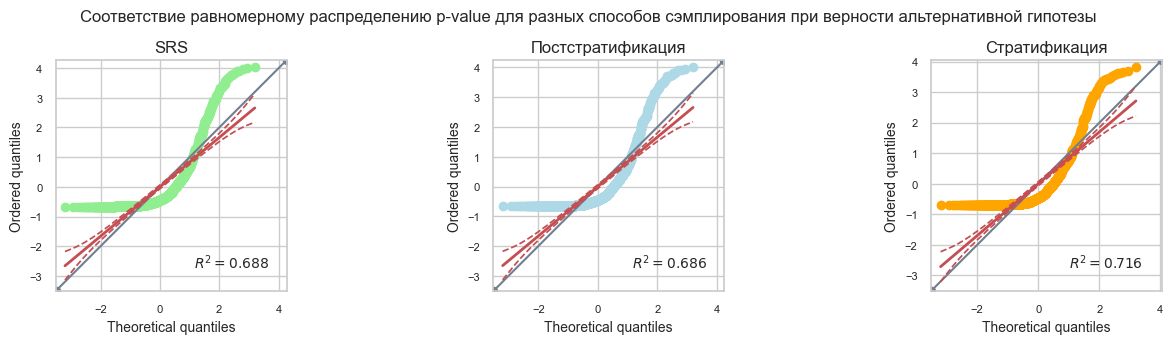

In [38]:
# оценка ошибки II рода

g_size, sample = 100000, 1000
mu, sigma, str_diff = 5, 1, 1.5
perc_grA, perc_grB = 0.5, 0.5
perc_str0, perc_str1 = 0.6, 0.4
alpha = 0.05
power = 0.8
eff = tt_ind_solve_power(alpha=alpha, power=power, nobs1=sample, ratio=1) * sigma

g_df0 = pd.DataFrame({'strat': 0, 'metric': np.random.normal(mu, sigma, int(perc_str0 * g_size))})
g_df1 = pd.DataFrame({'strat': 1, 'metric': np.random.normal(mu, sigma, int(perc_str1 * g_size))})
g_df = pd.concat([g_df0, g_df1]).reset_index(drop = True)

SRS_pval = []
SRS_str_pval = []
STR_pval = []

for _ in tqdm(range(1000)):
    # простое случайное сэмплирование (SRS)
    SRS = g_df.loc[np.random.choice(g_df.index, sample)]
    SRS['group'] = ['A']*int(perc_grA * sample) + ['B']*int(perc_grB * sample)
    SRS['metric'] = np.where(SRS['group'] == 'B', SRS['metric'] + eff, SRS['metric'])
    values_A = SRS.query('group == "A"')['metric'].values
    values_B = SRS.query('group == "B"')['metric'].values
    _, pvalue = stats.ttest_ind(values_A, values_B)
    SRS_pval.append(pvalue)

    # пост-стратификация
    values_0B = SRS.query('strat == 0 and group == "B"')['metric'].values
    values_0A = SRS.query('strat == 0 and group == "A"')['metric'].values
    values_1B = SRS.query('strat == 1 and group == "B"')['metric'].values
    values_1A = SRS.query('strat == 1 and group == "A"')['metric'].values
    
    mean_diff = (values_0B.mean() - values_0A.mean()) * perc_str0 + (values_1B.mean() - values_1A.mean()) * perc_str1
    var_B = values_0B.var(ddof = 0) * perc_str0 + values_1B.var(ddof = 0) * perc_str1
    var_A = values_0A.var(ddof = 0) * perc_str0 + values_1A.var(ddof = 0) * perc_str1
    var_diff = np.sqrt(var_A / len(SRS.query('group == "A"').values) + var_B / len(SRS.query('group == "B"').values))
    t_val = mean_diff / var_diff
    pvalue = (1 - stats.norm.cdf(np.abs(t_val))) * 2
    SRS_str_pval.append(pvalue)

    # стратифицированное сэмплирование (STR)
    str0_sample = g_df.query('strat == 0').sample(int(sample * perc_str0))
    str1_sample = g_df.query('strat == 1').sample(int(sample * perc_str1))
    str0_sample['group'] = ['A']*int(perc_grA * len(str0_sample)) + ['B']*int(perc_grB * len(str0_sample))
    str1_sample['group'] = ['A']*int(perc_grA * len(str1_sample)) + ['B']*int(perc_grB * len(str1_sample))
    STR = pd.concat([str0_sample, str1_sample])
    STR['metric'] = np.where(STR['group'] == 'B', STR['metric'] + eff, STR['metric'])
    
    values_0B = STR.query('strat == 0 and group == "B"')['metric'].values
    values_0A = STR.query('strat == 0 and group == "A"')['metric'].values
    values_1B = STR.query('strat == 1 and group == "B"')['metric'].values
    values_1A = STR.query('strat == 1 and group == "A"')['metric'].values
    
    mean_diff = (values_0B.mean() - values_0A.mean()) * perc_str0 + (values_1B.mean() - values_1A.mean()) * perc_str1
    var_B = values_0B.var(ddof = 0) * perc_str0 + values_1B.var(ddof = 0) * perc_str1
    var_A = values_0A.var(ddof = 0) * perc_str0 + values_1A.var(ddof = 0) * perc_str1
    var_diff = np.sqrt(var_A / len(SRS.query('group == "A"').values) + var_B / len(SRS.query('group == "B"').values))
    t_val = mean_diff / var_diff
    pvalue = (1 - stats.norm.cdf(np.abs(t_val))) * 2
    STR_pval.append(pvalue)

fig, axes = plt.subplots(1,3, figsize = (16,3))
ax1 = pg.qqplot(SRS_pval, ax = axes[0], color = 'lightgreen')
ax2 = pg.qqplot(SRS_str_pval, ax = axes[1], color = 'lightblue')
ax3 = pg.qqplot(STR_pval, ax = axes[2], color = 'orange')
ax1.set(title = 'SRS')
ax2.set(title = 'Постстратификация')
ax3.set(title = 'Стратификация')
fig.suptitle('Соответствие равномерному распределению p-value для разных способов сэмплирования при верности альтернативной гипотезы', y = 1.05)
fig.show()

Результаты симуляций показывают, что использование методов стратификации не меняет вероятность ошибок I и II рода. 

## CUPED (Controlled-experiment Using Pre-Experiment Data)

Метод CUPED заключается в том, чтобы использовать для оценки эффекта не исходную, а производную (прогнозную) метрику, которая рассчитывалась бы на данных, полученных до эксперимента. 

Идея метода заключается в том, что следует сравнивать не абсолютную разницу метрик после эксперимента между группами, а разницу между прогнозными значениями этих метрик. Прогноз строится из предположения, что при отсутствии эффекта экспериментальные данные будут повторять предэкспериментальные.
Если же эффект есть, то экспериментальные данные должны коррелировать с предэкспериментальными. 

**CUPED-метрика** выражается следующей формулой:
$$\Delta_{cuped} = \Delta_{exp} - \theta \cdot \Delta_{pre}$$

где: $\Delta_{exp}$ - величина эффекта во время эксперимента, $\Delta_{pre}$ - величина эффекта в предэкспериментальном периоде.

Для корректного применения этого метода необходимо разбиение на группы "расширить" и за пределы эксперимента: для пользователей, включённых в каждую группу, необходимо обогатить экспериментальные данные данными об их поведении до эксперимента, чтобы получить значение метрики $\Delta_{pre}$.

Это может быть затруднительно, если пользователи совершают редкие целевые действия:
* может быть меньше предэкспериментальная выборка;
* может быть длительным предэкспериментальный период.
  
Из-за этого предэкспериментальная метрика может оказаться смещённой, т.к. на неё будут действовать неконтролируемые факторы.

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:20<00:00, 483.35it/s]


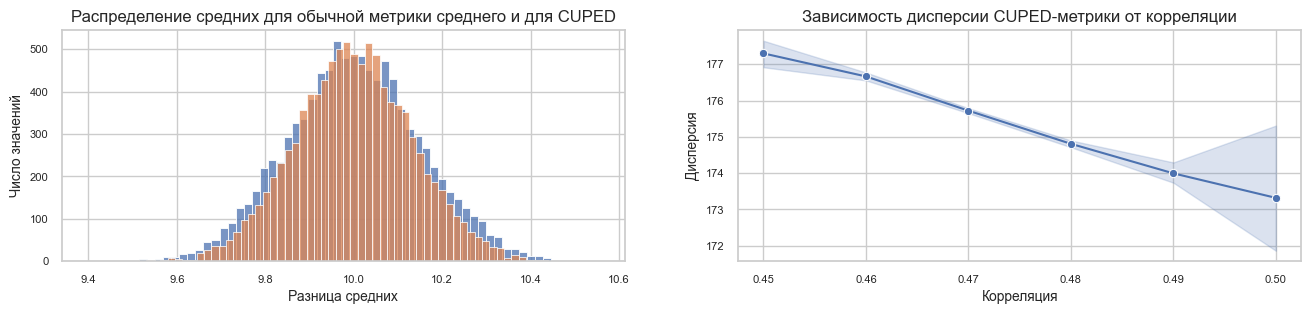

In [23]:
iterations = 10000

# предэкспериментальные параметры
mu, sigma, size = 50, 10, 10000

# параметры эффекта
eff, e_sigma = 10, 5

params = pd.DataFrame({'exp_means':[], 'cuped_means':[], 'correl':[], 'var_exp':[], 'var_cuped':[]})

counter = 0
for _ in tqdm(np.arange(iterations)):
    # данные до эксперимента по группам
    A_pre, B_pre = np.random.normal(mu, sigma, size), np.random.normal(mu, sigma, size)
    
    # экспериментальные данные
    A_exp = np.random.normal(mu, sigma, size)
    B_exp = B_pre + np.random.normal(eff, e_sigma, size)

    # значения метрик
    diff_pre = B_pre - A_pre
    diff_exp = B_exp - A_exp

    # параметры CUPED
    theta = np.cov(diff_exp, diff_pre, ddof=0)[0][1] / np.var(diff_pre, ddof=0)
    diff_cuped = diff_exp - theta * diff_pre
    
    corr_pre_exp = np.corrcoef(diff_pre, diff_exp)[0][1].round(2)
    var_exp = np.var(diff_exp, ddof=0)
    var_cuped = np.var(diff_cuped, ddof=0)

    params.loc[counter, 'exp_means'] = np.mean(diff_exp)
    params.loc[counter, 'cuped_means'] = np.mean(diff_cuped)
    params.loc[counter, 'correl'] = corr_pre_exp
    params.loc[counter, 'var_exp'] = var_exp
    params.loc[counter, 'var_cuped'] = var_cuped

    counter += 1

fig, axes = plt.subplots(1,2, figsize = (16,3))

ax1 = sns.histplot(data=params, x='exp_means', label='Обычная разница средних', ax=axes[0])
ax1 = sns.histplot(data=params, x='cuped_means', label='CUPED', ax=axes[0])
ax1.set(title = 'Распределение средних для обычной метрики среднего и для CUPED', xlabel='Разница средних', ylabel='Число значений')

ax2 = sns.lineplot(data=params, x='correl', y='var_cuped', ax=axes[1])
ax2.set(title='Зависимость дисперсии CUPED-метрики от корреляции', xlabel='Корреляция', ylabel='Дисперсия')

fig.show()

Преобразование CUPED способствует снижению дисперсии метрики по сравнению с дисперсией исходной метрики. Величина дисперсии зависит от корреляции между метрикой в эксперименте и предэкспериментальным значением. Чем выше корреляция, тем ниже дисперсия преобразованной метрики, и тем, соответственно выше разница дисперсий исходной и преобразованной метрик. 

Смоделируем различия для разных значений коэффициента корреляции:

In [3]:
iterations = 500

# предэкспериментальные параметры
mu, sigma, size = 0, 1, 10000

# параметры эффекта
eff = 2

# доля изменённых наблюдений
changes = np.arange(0.01, 1, 0.01)

params = pd.DataFrame({'exp_means':[], 'cuped_means':[], 'correl':[]})
counter = 0

for ch in tqdm(changes):
    for _ in range(iterations):
        x = pd.Series(np.random.normal(mu, sigma, size))
        changes_size = int(size * ch)
        y = x.copy() + eff
        changes_idx = np.random.choice(x.index, changes_size)
        y[changes_idx] = y[changes_idx] * (1 + np.random.normal(0, 1, changes_size))
        correl = np.corrcoef(y, x)[0][1]
        theta = np.cov(y, x, ddof=0)[0][1] / np.var(y, ddof=0)
        y_cuped = y - theta * x
    
        params.loc[counter, 'exp_means'] = np.mean(y)
        params.loc[counter, 'cuped_means'] = np.mean(y_cuped)
        params.loc[counter, 'correl'] = correl
    
        counter += 1

params['Rcorrel'] = params['correl'].round(1)
Y_std = params.groupby('Rcorrel', as_index = False).agg(Y_std = ('exp_means', 'std'), Y_cuped_std = ('cuped_means', 'std'))

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:36<00:00,  1.59s/it]


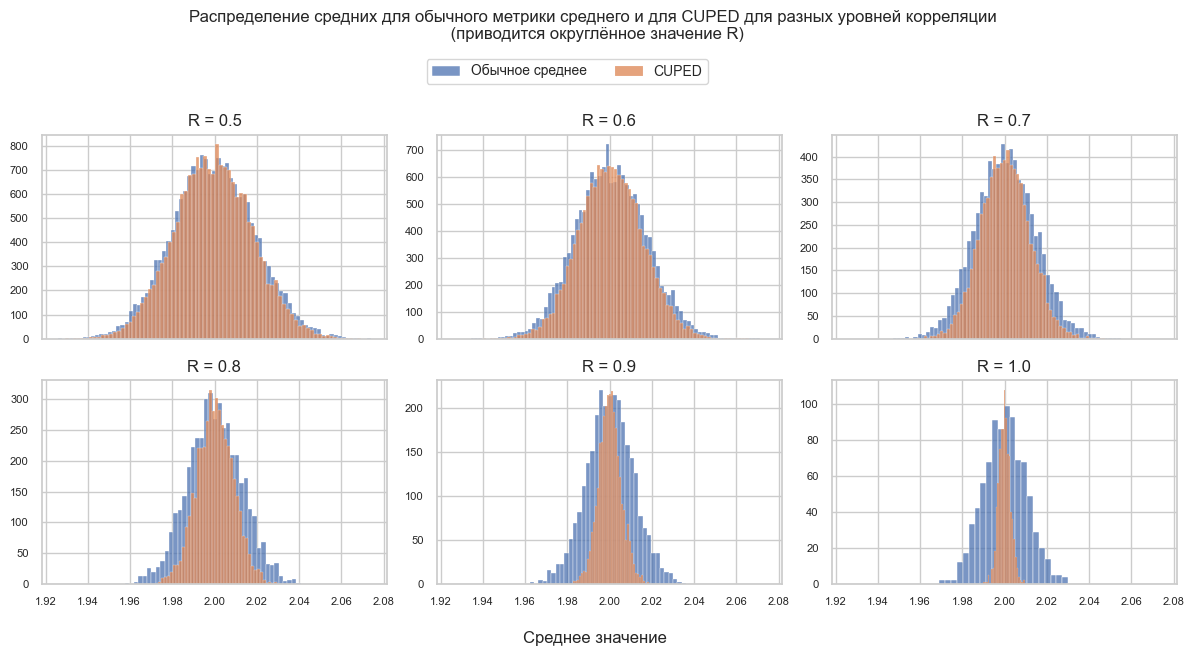

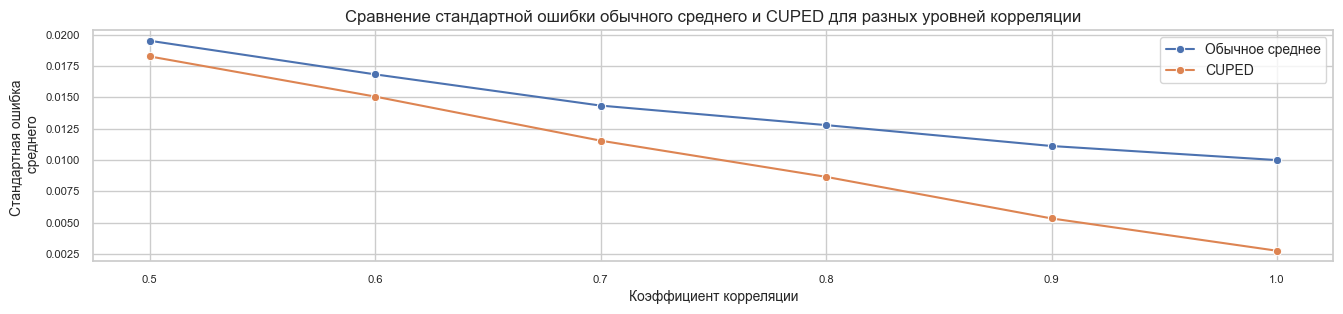

In [49]:
Correls = sorted(params['Rcorrel'].unique())
cols = 3
rows = np.ceil(len(Correls) / cols).astype(int)

fig, axes = plt.subplots(rows, cols, figsize = (12, 6), sharex = True)
xax = 0
yax = 0

counter = 0
for c in Correls:
    df = params.query('Rcorrel == @c')
    counter += 1
    ax = sns.histplot(data = df, x = 'exp_means', ax = axes[xax, yax])
    ax = sns.histplot(data = df, x = 'cuped_means', ax = axes[xax, yax])
    legend = axes[xax, yax].legend(labels = ['Обычное среднее', 'CUPED'])
    axes[xax, yax].get_legend().remove()
    ax.set(title=f'R = {c}', xlabel = '', ylabel = '')
    yax += 1
    if yax > 2:
        yax = 0
        xax += 1

fig.legend(handles = legend.legend_handles, labels = ['Обычное среднее', 'CUPED'], bbox_to_anchor = [0.6, 1], ncols = 2)
fig.supxlabel('Среднее значение')
fig.suptitle('Распределение средних для обычного метрики среднего и для CUPED для разных уровней корреляции \n (приводится округлённое значение R)', y = 1.07)
fig.tight_layout()
fig.show()

plt.figure(figsize=(16,3))
sns.lineplot(data = Y_std, x = 'Rcorrel', y = 'Y_std', label = 'Обычное среднее')
sns.lineplot(data = Y_std, x = 'Rcorrel', y = 'Y_cuped_std', label = 'CUPED')
plt.xlabel('Коэффициент корреляции')
plt.ylabel('Стандартная ошибка \n среднего')
plt.title('Сравнение стандартной ошибки обычного среднего и CUPED для разных уровней корреляции')
plt.show()

Симуляция подтверждает эффективность метода CUPED для снижения дисперсии, которая зависит от величины корреляции между экспериментальными и предэкспериментальными данными - чем выше корреляции, тем более эффективен метод.

**Техника использования метода.**

_**На подготовительном этапе:**_
1. С пред-экспериментального периода мы собираем значения основной метрики, а с пред-пред-экспериментального периода для тех же пользователей мы собираем значения ковариаты (значения метрики с предыдущего периода);
2. Проводим процедуру преобразования метрики CUPED;
3. Оцениваем дисперсию преобразованной метрики;
4. Считаем необходимый размер групп.

_**На этапе эксперимента:**_
1. С экспериментального периода собираем значения основной метрики, а с пред-экспериментального периода для тех же пользователей собираем значения ковариаты;
2. Проводим процедуру преобразования метрики;
3. Для получившейся метрики проводим t-test;
4. Принимаем решение о успехе или неудаче нашего эксперимента.

## Множественное тестирование

При параллельном запуске нескольких независимых экспериментов **(M)** увеличивается вероятность того, что хотя бы в одном из них значимое изменение будет обнаружено случайно, когда на самом деле отличий нет, т.е. будет допущена ошибка I рода. 

Метрика вероятности ошибки I рода при множественном тестировании называется **FWER** (Family-Wise Error Rate): $FWER = 1 - (1-\alpha)^M$ 

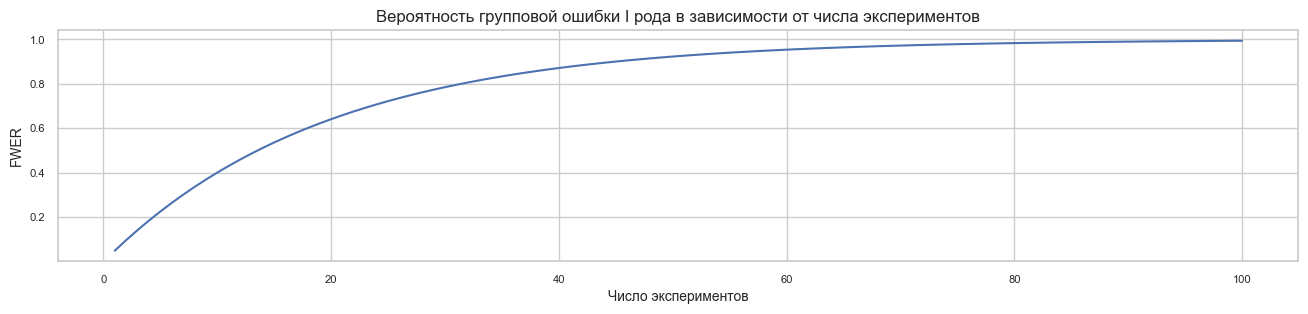

In [16]:
alpha = 0.05
exp_num = np.arange(1, 101)
fwer = 1 - (1 - alpha)**exp_num

plt.figure(figsize = (16,3))
plt.plot(exp_num, fwer, marker='')
plt.xlabel('Число экспериментов')
plt.ylabel('FWER')
plt.title('Вероятность групповой ошибки I рода в зависимости от числа экспериментов')
plt.show()

### Поправка Бонферрони

Эта поправка предполагает, что при запуске нескольких экспериментов до их начала необходимо скорректировать величину $\alpha$ на число экспериментов:
$$\tilde{\alpha} = \alpha / M$$

И далее результат эксперимента оценивается по скорректированному значению $\tilde{\alpha}$.

Известно, что если эффекта нет, то p-value распределён равномерно. Тогда можно смоделировать эти значения и проверить, контролируется ли ошибка I рода с помощью этой поправки. 

### Поправка Холма

Этот метод предполагает корректировать p-value не до эксперимента, а после, на базе тех значений p-value, которые были получены для эксперимента как единичного и независимого. Алгоритм метода следующий:
* проводится множество экспериментов, в каждом оценивается p-value;
* каждому значению присваивается ранг: самый высокий - самому большому значению, самый низкий - самому маленькому;
* рассчитывается порогое значение $\tilde{\alpha}$ для каждого эксперимента: $$\tilde{\alpha_i} = \alpha \ / \ {rank}_i$$
* принимается решение об отвержении или не отвержении нулевой гипотезы для конкретного эксперимента на основе $\tilde{\alpha_i}$.


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:06<00:00,  7.69it/s]


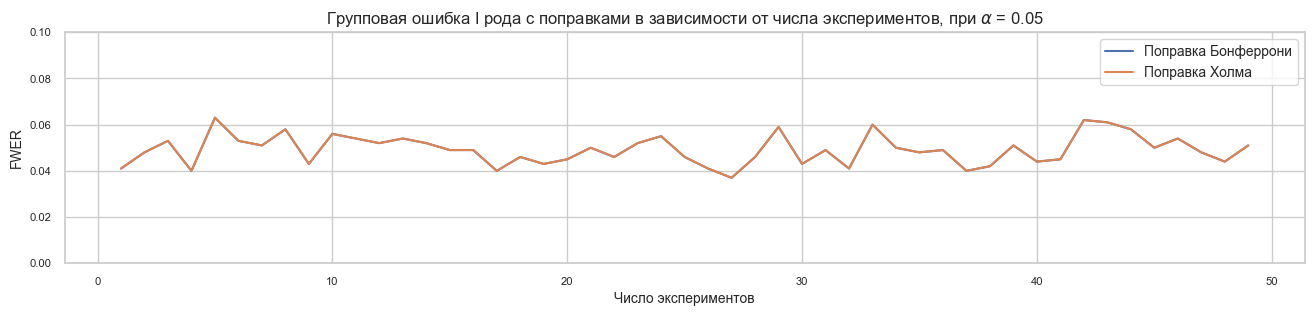

In [240]:
alpha = 0.05
size = np.arange(1, 50)
iters = 1000
bonf_fwer_lst = []
holm_fwer_lst = []

for s in tqdm(size):
    list_pvalues = [np.random.rand(s) for _ in range(iters)]
    res_bonf = [int((pvalues <= alpha / s).sum() > 0) for pvalues in list_pvalues]
    fwer_bonf = np.mean(res_bonf)
    bonf_fwer_lst.append(fwer_bonf)
    res_holm = [int((pvalues <= alpha / pd.Series(pvalues).rank(ascending = False).values).sum() > 0) for pvalues in list_pvalues]
    fwer_holm = np.mean(res_holm)
    holm_fwer_lst.append(fwer_holm)

plt.figure(figsize = (16,3))
plt.plot(size, bonf_fwer_lst, marker='', label = 'Поправка Бонферрони')
plt.plot(size, holm_fwer_lst, marker='', label = 'Поправка Холма')
plt.ylim([0,0.1])
plt.xlabel('Число экспериментов')
plt.ylabel('FWER')
plt.legend()
plt.title(r'Групповая ошибка I рода с поправками в зависимости от числа экспериментов, при $\alpha$ = 0.05')
plt.show()

Обе поправки позволяют контролировать ошибку I рода. 

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [07:43<00:00, 15.46s/it]


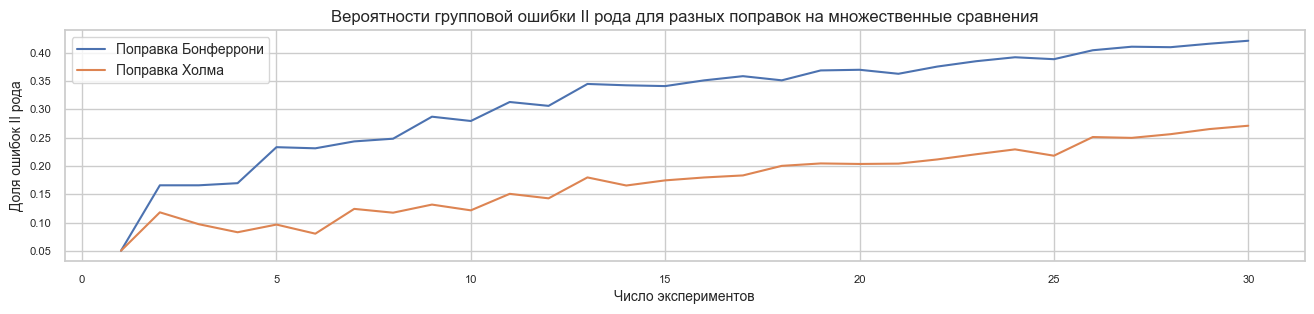

In [77]:
mu = 100
sigma = 10
size = 1000
eff = 1.5
alpha = 0.05
iters = 200
exps = np.arange(1, 31)
bonf_type_II = []
holm_type_II = []

pvals_stat = pd.DataFrame({'NumExps': [], 'CurrExp': [], 'Iteration': [], 'pval': []})

for exp in tqdm(exps):
    for i in range(1, exp+1):
        for j in range(1, iters):
            A_group = np.random.normal(mu, sigma, size)
            B_group = np.random.normal(mu+eff, sigma, size)
            pval = pg.ttest(B_group, A_group)['p-val'][0]
            res = pd.DataFrame({'NumExps': exp, 'CurrExp': i, 'Iteration': j, 'pval': pval}, index=[0])
            pvals_stat = pd.concat([pvals_stat, res])

pvals_stat['Bonf_alpha'] = alpha / pvals_stat['NumExps']
pvals_stat.reset_index(drop=True, inplace=True)
pvals_stat['pval_rnk'] = pvals_stat.groupby(['NumExps', 'Iteration'], as_index=False)['pval'].rank(ascending=False)
pvals_stat['Holm_alpha'] = alpha / pvals_stat['pval_rnk']
pvals_stat['Bonf_fn'] = np.where(pvals_stat['pval'] > pvals_stat['Bonf_alpha'], 1, 0)
pvals_stat['Holm_fn'] = np.where(pvals_stat['pval'] > pvals_stat['Holm_alpha'], 1, 0)

fn_stat = pvals_stat.groupby('NumExps', as_index = False).agg(Bonf_fn = ('Bonf_fn', 'mean'), Holm_fn = ('Holm_fn', 'mean'))

plt.figure(figsize = (16,3))
plt.plot(fn_stat['NumExps'], fn_stat['Bonf_fn'], marker='', label='Поправка Бонферрони')
plt.plot(fn_stat['NumExps'], fn_stat['Holm_fn'], marker='', label='Поправка Холма')
plt.legend()
plt.xlabel('Число экспериментов')
plt.ylabel('Доля ошибок II рода')
plt.title('Вероятности групповой ошибки II рода для разных поправок на множественные сравнения')
plt.show()

Поправка Холма допускает меньшую вероятность групповой ошибки II рода при множественных экспериментах. 

Если выборка достаточно большая, то это позволяет параллельно проводить много экспериментов. Но если выборка ограничена, тогда и количество одновременных экспериментов ограничивается, поскольку в каждом эксперименте необходимо набрать выборку, которая позволит получить MDE, с учётом индивидуальной и групповой ошибки II рода. 

### Организационные аспекты параллельного запуска экспериментов

Параллельный запуск экспериментов становится актуальным тогда, когда у компании много гипотез по улучшению показателей и есть возможность разделить текущий поток пользователей на несколько групп, чтобы в каждой проводить свои эксперименты. Если запускать по одному эксперименту последовательно, то это приведёт к тому, что компания может недозаработать, а хорошие гипотезы будут долго находиться в очереди. 

Однако при параллельном запуске эксперименты не должны влиять друг на друга. И чтобы избежать этого, существует несколько схем запуска:
* **Одномерная схема** - каждый пользователь попадает не более, чем в один эксперимент в текущем отрезке времени. Эта схема возможна при небольшом числе экспериментов. Допустим, если база пользователей 1 000 000 человек, и в каждом эксперименте для стат. значимых отличий нужно не меньше 10 000 человек, то максимум в таком случае можно запустить параллельно 100 экспериментов. 
* **Многомерная схема** - пользователь может одновременно оказаться более, чем в одном эксперименте, если эти эксперименты относятся к разной функциональности / сервису и не влияют на поведение пользователя в отношении параллельного эксперимента.

#### Варианты многомерных схем

* **Коррелированные группы**
    * когда часть пользователей определена только как контрольная группа в серии параллельных тестов, а другая - только как тестовая. В таком случае на пользователях тестовой группы сразу проверяется несколько новых "фичей". Если в этих экспериментах одинаковая метрика качества, то это будет проблемой, поскольку не будет возможности понять, за счёт какой из них получен этот результат или как как распределяется эффект. Также возможен эффект сложения незначимых эффектов, из-за чего он станет значимым. 
    * когда в 1-м эксперименте пользователи тестовой группы являются пользователями контрольной группы во 2-м эксперименте и наоборот. Если в экспериментах одинаковая метрика, то это снова не даст возможности понять, за счёт чего достигнут эффект, а также можно пропустить эффект от отдельных "фичей", если он будет разнонаправленным.

Поэтому схема с коррелированными группами допустима только в случае, когда параллельные эксперименты оцениваются с помощью разных метрик.

* **Некоррелированные группы** - строятся таким образом, чтобы пользователи, участвующие в экспериментах, были одинаково представлены как в группе А, так и в группе В во всех экспериментах. Это распределение называется _ортогональным_. Например, если проводится 2 параллельных эксперимента с одной метрикой:
    * в 1-м эксперименте группа А1: пользователи оттуда во 2-м эксперименте находятся в равных пропорциях и в группе А2, и в группе В2.
    * в 1-м эксперименте группа В1: пользователи оттуда во 2-м эксперименте находятся в равных пропорциях и в группе А2, и в группе В2.
    * во 2-м эксперименте группа А2: пользователи оттуда в 1-м эксперименте находятся в равных пропорциях и в группе А1, и в группе В1.
    * во 2-м эксперименте группа В2: пользователи оттуда в 1-м эксперименте находятся в равных пропорциях и в группе А1, и в группе В1.

Однако _ортогональное распределение_ не исключает негативных эффектов, если параллельные эксперименты связаны с _одной функциональностью_, а отслеживать это в случае большого потока экспериментов затруднительно. Поэтому на практике, если пользовательская база большая, то всех пользователей разделяют на слоты.

#### Разделение пользователей на слоты и слои

* **Слот (Slot)** - часть пользователей, выделенная для проведения эксперимента. 
* **Слой (Layer)** - определённая ветка изменений / функциональности (например, алгоритмы ранжирования, дизайна, конкретные страницы). 

При большой пользовательской базе и постоянных экспериментах пользователи могут одновременно участвовать во всех слоях, но при этом в каждом слое они могут участвовать только в одном эксперименте. Для корректного разбиения используется процедура "двойного просаливания":
* каждый слой имеет свой уникальный идентификатор (соль), на основе которой вычисляется хэш-функция и производится дальнейшее разбиение по слотам, отведённым этому слою;
* в зависимости от слота, куда попал пользователь, он будет определён в тот эксперимент, который определено проводить на этих слотах;
* для определения группы эксперимента пользователь "просаливается" второй раз, на основе идентификатора (соли) этого уникального эксперимента, и далее на основе хэш-функции определяется в экспериментальную, либо контрольную группу.

При этом для важных изменений обычно принято выделять также отдельную группу пользователей **(exclusive)**, которые не участвуют ни в каких экспериментах.

При использовании нескольких слотов в одном слое может возникать **проблема статичности слотов**. Она заключается в том, что если пользователи участвовали в эксперименте, то эксперимент мог повлиять на их последующее поведение, и к следующему эксперименту пользователи в разных слотах не будут одинаковы. Для преодоления этой проблемы, если предполагается использовать те же слоты, их нужно перемешать между собой и на основе хэширования создать новые тестовую и контрольную группу (т.е. пользователь подвергается _повторному хэшированию_ в следующем эксперименте).

In [174]:
# создаём 1 млн. пользователей, которые будут посещать сервис
# создаём 4 слоя и в каждом разное число слотов
# добавляем соль к каждому пользователю количество раз, равное числу слотов
# исходя из полученного хэша в каждом слое решаем, в какой слот упадёт пользователь
# в зависимости от слота определяем, в какой эксперимент на слое пользователь попадёт
# производим повторное просаливание пользователя, чтобы определить в какую группу он попадёт

import uuid
import hashlib

num_users = 1000000
layers = ['ui', 'algo', 'feature', 'comms'] 
layer_slots = [5, 9, 8, 4] # число слотов в каждое слое
layer_exps = [2, 3, 4, 2] # число экспериментов в каждом слое

# доля траффика на экспериментальный период от всех пользователей
exp_traffic = 0.1

uuids = [str(uuid.uuid4()) for i in range(num_users)]
x = (np.random.rand(num_users) <= exp_traffic)*1

df = pd.DataFrame({'user_id': uuids})
df['is_visitor'] = x
df_exp = df.query('is_visitor == 1').drop('is_visitor', axis=1).copy()

def get_hash_int(string: str):
    hash_val = hashlib.md5(string.encode('utf-8')).hexdigest()
    resid = int(hash_val, 16) % 100
    return resid

for l in range(len(layers)):
    df_exp['hash_'+str(layers[l])] = df_exp['user_id'].apply(lambda x: get_hash_int(x+layers[l]))
    df_exp['slot_'+str(layers[l])] = pd.cut(df_exp['hash_'+str(layers[l])], bins=layer_slots[l], 
                                            labels=[i for i in range(1, layer_slots[l]+1)], right=False)
    df_exp['layer_exp_'+str(layers[l])] = df_exp['slot_'+str(layers[l])] \
                                                .apply(lambda x: np.ceil(np.divide(x, layer_slots[l] / layer_exps[l])) \
                                                                         if np.ceil(np.divide(x, layer_slots[l] / layer_exps[l])) <= layer_exps[l] \
                                                                         else layer_exps[l] \
                                                      )
    df_exp['hash_exp_group_'+str(layers[l])] = df_exp['user_id'].apply(lambda x: get_hash_int(x+layers[l]+'layer_exp_'+str(layers[l])))
    df_exp['exp_group_'+str(layers[l])] = pd.cut(df_exp['hash_exp_group_'+str(layers[l])], bins=[0, 50, 100], labels=['A', 'B'], right=False)

df_exp = df_exp.drop(df_exp.columns[(df_exp.columns.str.startswith('hash') | df_exp.columns.str.startswith('slot'))], axis=1)

In [194]:
print('\nРаспределение пользователей по экспериментам:')
display(df_exp.head(10))

df_exp_stat = df_exp.copy()
df_exp_stat['user_groups'] = df_exp_stat[df_exp.columns[df_exp.columns.str.startswith('exp_group_')]].to_numpy().sum(axis = 1)
df_exp_stat['A_groups'] = df_exp_stat['user_groups'].str.count('A')
df_exp_stat['B_groups'] = df_exp_stat['user_groups'].str.count('B')
exp_stat = df_exp_stat.groupby(['A_groups', 'B_groups'], as_index = False) \
                         .agg(Users = ('user_id', 'nunique')) \
                         .assign(Percent = lambda x: x['Users'] * 100 / x['Users'].sum())

print('\nСтатистика распределения:')
display(exp_stat)

layer = df_exp.columns[df_exp.columns.str.startswith('layer_exp')]
group = df_exp.columns[df_exp.columns.str.startswith('exp_group')]

layers_distr = pd.DataFrame({})
for l in range(len(layers)):
    l_d = df_exp.groupby([layer[l], group[l]], as_index=False).agg(Users = ('user_id', 'nunique')).rename(columns={layer[l]:'NumExp', group[l]:'Group'})
    l_d['layer'] = layers[l]
    l_d['layer_exp'] = layers[l] + '_' + l_d['NumExp'].astype(int).astype(str)
    layers_distr = pd.concat([layers_distr, l_d])

layers_distr.drop('NumExp', axis = 1, inplace = True)

print('Распределение пользователей по экспериментам и слоям:')
display(layers_distr.head(10))


Распределение пользователей по экспериментам:


,user_id,layer_exp_ui,exp_group_ui,layer_exp_algo,exp_group_algo,layer_exp_feature,exp_group_feature,layer_exp_comms,exp_group_comms
0,7b97975a-8f23-4d29-84e0-a7b7e8a761cb,1.00,B,3.00,A,2.00,A,1.00,A
26,5c95f66d-5c94-44c1-8a3e-7ba552ef535d,1.00,B,3.00,A,1.00,A,1.00,B
37,70d49c5f-939c-4db9-b997-fc7de8006899,2.00,A,1.00,B,1.00,A,2.00,A
64,833246fe-9d14-4064-8b39-7933907bbcc9,2.00,B,1.00,B,1.00,A,1.00,B
65,457a351d-c1a0-44ae-b88c-a1cfe0e01295,2.00,B,2.00,A,2.00,A,1.00,B
67,e283632b-2f08-4259-a402-5edc5b6a313c,2.00,B,2.00,B,2.00,B,2.00,B
83,acffc43d-e5d7-4458-a5f9-e68ba8ffa91e,2.00,A,2.00,B,1.00,A,2.00,A
89,1537d330-15d5-45a3-824b-af10ab48bd86,1.00,B,1.00,B,3.00,A,1.00,B
99,a8c3248b-2a0f-4e57-be72-da5656ba10a2,1.00,B,1.00,B,4.00,B,1.00,B
102,b5e68d2c-b01f-4127-8e00-1a349aa7133b,1.00,A,3.00,B,2.00,B,2.00,A



Статистика распределения:


,A_groups,B_groups,Users,Percent
0,0,4,6184,6.18
1,1,3,25174,25.15
2,2,2,37611,37.57
3,3,1,24909,24.88
4,4,0,6221,6.21


Распределение пользователей по экспериментам и слоям:


,Group,Users,layer,layer_exp
0,A,20180,ui,ui_1
1,B,19931,ui,ui_1
2,A,30033,ui,ui_2
3,B,29955,ui,ui_2
0,A,16545,algo,algo_1
1,B,16412,algo,algo_1
2,A,16578,algo,algo_2
3,B,16454,algo,algo_2
4,A,16991,algo,algo_3
5,B,17119,algo,algo_3


In [200]:
Image(url="https://i.ibb.co/Gvy4cCs1/deepseek-mermaid-20250924-fe37ec.png", width=13123, height=2586)

## Метрики отношения

**Метрика отношения** - это метрика, вычисляемая как отношение двух величин, причём обе зависят от одного и того же фактора. 

Примеры:
* средний чек - числитель метрики: выручка - это сумма произведений индивидуальных чеков на количество товаров, знаменатель: сумма количества товаров. И в числителе и в знаменателе - количество товаров.
* средняя длина сессии - числитель метрики: общая длина сессий - сумма всех длин сессий, которая тем больше, чем больше их количество; в знаменателе - число сессий. Таким образом числитель и знаменатель коррелированы.

Сгенерируем пользовательские сессии и проанализируем поведение метрики средней длины сессии. 

In [2]:
# Сгенерируем пользовательские сессии (1000 пользователей за 30 дней)

from faker import Faker
import random
from typing import List, Dict

users = 1000
days = 30

fake = Faker()

def generate_user_sessions(num_users: int = 1000, days: int = 30) -> pd.DataFrame:
    """
    Генерирует сессии для пользователей за указанный период
    
    Args:
        num_users: количество пользователей
        days: количество дней для генерации данных
    
    Returns:
        DataFrame с сессиями пользователей
    """
    sessions = []
    start_date = dt.now() - td(days=days)
    
    for user_id in range(1, num_users + 1):
        user_sessions = generate_single_user_sessions(user_id, start_date, days)
        sessions.extend(user_sessions)
    
    return pd.DataFrame(sessions)

def generate_single_user_sessions(user_id: int, start_date: dt, days: int) -> List[Dict]:
    """
    Генерирует сессии для одного пользователя
    """
    user_sessions = []
    current_date = start_date
    
    # Определяем паттерн пользователя
    pattern_type = random.choice(['morning', 'afternoon', 'evening', 'mixed', 'frequent'])
    
    for week in range(4):  # 4 недели в месяце
        week_sessions = generate_weekly_sessions(user_id, current_date, pattern_type)
        user_sessions.extend(week_sessions)
        current_date += td(days=7)
    
    return user_sessions

def generate_weekly_sessions(user_id: int, week_start: dt, pattern_type: str) -> List[Dict]:
    """
    Генерирует сессии на одну неделю в соответствии с паттерном пользователя
    """
    sessions = []
    days_in_week = 7
    
    # Минимум 3 сессии в неделю
    min_sessions = 3
    max_sessions = {
        'morning': 5,
        'afternoon': 6,
        'evening': 5,
        'mixed': 7,
        'frequent': 14  # Очень активные пользователи
    }[pattern_type]
    
    num_sessions = random.randint(min_sessions, max_sessions)
    session_days = random.sample(range(days_in_week), min(num_sessions, days_in_week))
    
    for day_offset in session_days:
        session_date = week_start + td(days=day_offset)
        
        # Генерируем от 1 до 3 сессий в день в зависимости от паттерна
        daily_sessions = random.randint(1, 3) if pattern_type == 'frequent' else 1
        
        for _ in range(daily_sessions):
            session = generate_single_session(user_id, session_date, pattern_type)
            if session:
                sessions.append(session)
    
    return sessions

def generate_single_session(user_id: int, session_date: dt, pattern_type: str) -> Dict:
    """
    Генерирует одну сессию пользователя
    """
    # Определяем время начала в зависимости от паттерна
    if pattern_type == 'morning':
        start_hour = random.randint(6, 10)
    elif pattern_type == 'afternoon':
        start_hour = random.randint(12, 16)
    elif pattern_type == 'evening':
        start_hour = random.randint(18, 23)
    else:  # mixed и frequent
        start_hour = random.randint(0, 23)
    
    start_minute = random.randint(0, 59)
    start_second = random.randint(0, 59)
    
    session_start = session_date.replace(
        hour=start_hour, 
        minute=start_minute, 
        second=start_second,
        microsecond=0
    )
    
    # Длительность сессии в зависимости от паттерна
    base_durations = {
        'morning': (5, 25),      # Короткие утренние сессии
        'afternoon': (10, 45),   # Средние дневные сессии
        'evening': (15, 120),    # Длинные вечерние сессии
        'mixed': (5, 90),        # Разнообразные сессии
        'frequent': (1, 30)      # Короткие частые сессии
    }
    
    min_dur, max_dur = base_durations[pattern_type]
    
    # Добавляем случайность в длительность
    duration_variation = random.choice(['short', 'medium', 'long'])
    if duration_variation == 'short':
        duration = random.randint(min_dur, min_dur + 10)
    elif duration_variation == 'medium':
        duration = random.randint((min_dur + max_dur) // 2 - 5, (min_dur + max_dur) // 2 + 5)
    else:
        duration = random.randint(max_dur - 10, max_dur)
    
    session_end = session_start + td(minutes=duration)
    
    return {
        'user_id': user_id,
        'session_start': session_start,
        'session_end': session_end,
        'session_duration_minutes': duration,
        'pattern_type': pattern_type
    }

In [3]:
# Генерируем сессии

df_sessions = pd.DataFrame({'A_Total': [], 'A_user': [], 'B_Total': [], 'B_user': []})
iters = 1000

for _ in tqdm(range(iters)):
    sessions_df = generate_user_sessions(
                        num_users=users, 
                        days=days, 
                    )
    
    sessions_df['duration_sec'] = (sessions_df['session_end'] - sessions_df['session_start']).dt.seconds
    A_group = np.random.choice(sessions_df['user_id'].unique(), users // 2, replace=False)
    sessions_df['group'] = np.where(sessions_df['user_id'].isin(A_group), 'A', 'B')

    mean_total = sessions_df.groupby('group')['duration_sec'].mean()
    mean_total_A = mean_total.loc['A']
    mean_total_B = mean_total.loc['B']
    
    mean_user = sessions_df.groupby(['group', 'user_id'], as_index=False)['duration_sec'].mean().groupby('group')['duration_sec'].mean()
    mean_user_A = mean_user.loc['A']
    mean_user_B = mean_user.loc['B']
    
    stat_sessions = pd.DataFrame({'A_Total': [mean_total_A], 'A_user': [mean_user_A], 'B_Total': [mean_total_B], 'B_user': [mean_user_B]})
    df_sessions = pd.concat([df_sessions, stat_sessions])

direction_up = (df_sessions['A_Total'] < df_sessions['B_Total']) & (df_sessions['A_user'] < df_sessions['B_user'])
direction_down = (df_sessions['A_Total'] > df_sessions['B_Total']) & (df_sessions['A_user'] > df_sessions['B_user'])
direction_diff = ~(direction_up | direction_down)

df_sessions['WrongDirection'] = np.where(direction_diff, 1, 0)
wrong_direction_percent = df_sessions['WrongDirection'].mean() * 100
print(f'Доля сессий, где средняя длина сессии не сонаправлена со средней длинной сессии, вычисленной по пользователям: {wrong_direction_percent}%')

sessions_df.drop('group', axis=1, inplace=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:02<00:00,  4.13it/s]

Доля сессий, где средняя длина сессии не сонаправлена со средней длинной сессии, вычисленной по пользователям: 12.9%


Средняя длина сессии, вычисленная без разбиения по пользователям, отличается от средней длины, если бы она сначала считалась для каждого пользователя, а затем усреднялась. Проблема метрики отношения в том, что эти две средние могут иметь не сонаправленный эффект (выше указан % таких случаев на симулированных данных). 

Кроме того, распределение метрики среднего значения не будет нормальным. Рассмотрим на примере последней симуляции через bootstrap. 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 71.82it/s]


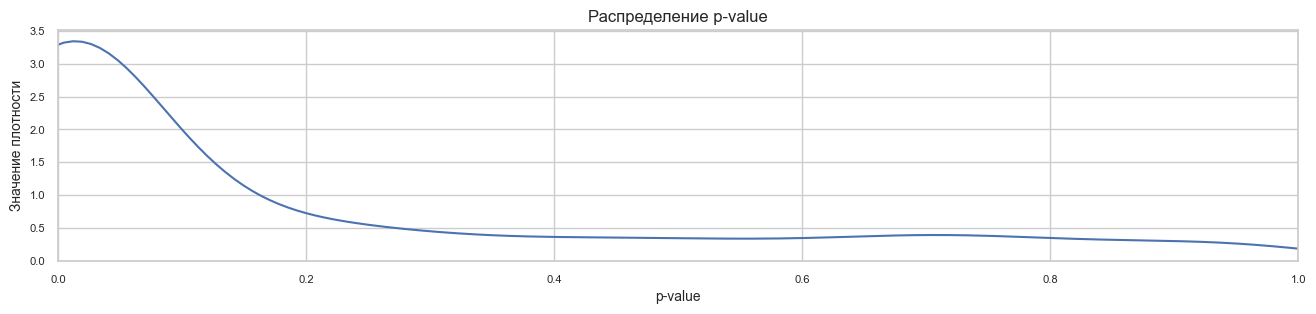

In [24]:
pvals = []
for _ in tqdm(range(iters)):
    A_group_1 = np.random.choice(sessions_df['user_id'].unique(), users // 2, replace=False)
    sessions_df['group'] = np.where(sessions_df['user_id'].isin(A_group_1), 'A1', 'A2')
    A1_vals = sessions_df.query('group == "A1"')['duration_sec'].values
    A2_vals = sessions_df.query('group == "A2"')['duration_sec'].values
    pval = pg.ttest(A1_vals, A2_vals)['p-val'][0]
    pvals.append(pval)

plt.figure(figsize = (16,3))
sns.kdeplot(pvals, marker='')
plt.xlim(0, 1)
plt.ylabel('Значение плотности')
plt.xlabel('p-value')
plt.title('Распределение p-value')
plt.show()

Поэтому стандартные тесты для таких метрик не подходят. Есть несколько подходов проверки статистических гипотез в этом случае:
* дельта-метод;
* линеаризация;
* bootstrap.

### Дельта-метод

Это способ построения распределения для произвольной функции от среднего значения. Формулировка метода:

* пусть существует выборка $x_1, x_2, ..., x_n \backsim iid. N(\mu; \sigma^2)$
* и существует функция $g(t)$, являющаяся непрерывно дифференцируемой.

Тогда функция g от среднего значения будет иметь нормальное распределение с параметрами: 
$$g(\bar{x}) \backsim N(g(\mu); \frac{\sigma^2}{n} \cdot g'(\mu)^2)$$

Данный метод может быть обобщён на случай нескольких выборок. 

Например, для двух выборок:
* $X \backsim N(\mu_x; \sigma_x^2); Y \backsim N(\mu_y; \sigma_y^2)$
* непрерывно дифференцируемая функция $g(t_1, t_2)$

Тогда функция g от среднего значения двумерной случайно величины $\theta = (x, y)$ будет иметь двумерное нормальное распределение с параметрами: 
$$g(\hat{\theta}) \backsim N(g(\theta); \hat{g}^T \cdot \hat{\sum} \cdot \hat{g})$$
где: $$\hat{\sum} = \frac{1}{n} \cdot \left( \begin{array}{cc} \sigma_x^2 & \sigma_{xy}^2 \\
\sigma_{xy}^2 & \sigma_y^2 \end{array} \right), \hat{g} = (\frac{\partial{g}}{\partial{x}}, \frac{\partial{g}}{\partial{y}})$$

В случае метрики отношения функция g будет иметь вид: $g = \frac{t_1}{t_2}$, а её реализация: $\hat{\theta} = \frac{\bar{x}}{\bar{y}}$. Соответственно, оценка параметров распределения: 
$$g(\hat{\theta}) \backsim N\left(\frac{\bar{x}}{\bar{y}}; \left( \begin{array}{c} \frac{1}{\bar{y}} , -\frac{\bar{x}}{\bar{y}} \end{array} \right) \cdot \frac{1}{n} \cdot \left( \begin{array}{cc} \sigma_x^2 & \sigma_{xy}^2 \\
\sigma_{xy}^2 & \sigma_y^2 \end{array} \right) \cdot \left( \begin{array}{c} \frac{1}{\bar{y}} , -\frac{\bar{x}}{\bar{y}} \end{array} \right)^T\right)$$

Раскрывая формулу, получаем следующую оценку дисперсии метрики отношения: 
$$\sigma^2_{\bar{x} / \bar{y}} = \frac{1}{n} \cdot \left( \frac{\sigma^2_x}{\bar{y}^2} - 2\frac{\bar{x} \cdot \sigma^2_{xy}}{\bar{y}^3} + \frac{\bar{x}^2 \cdot \sigma_y^2}{\bar{y}^4}\right)$$

Получив её, можно подставлять это значение дисперсии в формулу t-теста, чтобы реализовать проверку гипотезы о равенстве средних значений метрики отношения. Обычный t-тест с дисперсией, вычисленной по выборке, будет давать некорректные результаты. 

В случае с метрикой средней длительности сессии:
* x - средняя длительность сессии на пользователя;
* y - среднее число сессий на пользователя.

Сравним оценку дисперсии, полученной через дельта-метод, bootstrap и расчётным способом. 

In [5]:
calc_delta = sessions_df.groupby('user_id', as_index=False) \
                        .agg(SessionsCnt = ('user_id', 'count'), 
                             TotalSessionDuration = ('duration_sec', 'sum'),
                             AvgSessionDuration = ('duration_sec', 'mean')
                            )

calc_std_session_duration = calc_delta['AvgSessionDuration'].std(ddof=0).round(0)

mean_x = calc_delta['TotalSessionDuration'].mean()
mean_y = calc_delta['SessionsCnt'].mean()
covar_xy = np.cov(calc_delta['TotalSessionDuration'], calc_delta['SessionsCnt'])

delta_std = np.sqrt( \
                (covar_xy[0,0]  + (mean_x**2) * covar_xy[1,1] / (mean_y**2) - 2 * (mean_x * covar_xy[0,1]) / mean_y) \
                / ((mean_y**2) * calc_delta.shape[0])
                )

boot_sample = 300
boots_avg = []
for _ in tqdm(range(iters)):
    smpl = np.random.choice(calc_delta['user_id'].unique(), boot_sample, replace=False)
    df = calc_delta[calc_delta['user_id'].isin(smpl)].copy()
    avg_session = df['TotalSessionDuration'].sum() / df['SessionsCnt'].sum()
    boots_avg.append(avg_session)

print('\nОценка стандартного отклонения метрики:')
print(f'- через обычный расчёт по выборке: {round(calc_std_session_duration,0)}')
print(f'- дельта-методом: {round(delta_std,0)}')
print(f'- через bootstrap: {round(np.array(boots_avg).std(ddof=0), 0)}')

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1490.88it/s]


Оценка стандартного отклонения метрики:
- через обычный расчёт по выборке: 1249.0
- дельта-методом: 37.0
- через bootstrap: 56.0


Недостаток использования дельта-метода для оценки дисперсии - невозможность применять техники для снижения дисперсии, расчёт необходимо производить по исходной выборке и переменной. 

### Линеаризация

Суть данного способа - в переходе к другой метрике, рассчитанной на основе исходных. 
Для его использования необходимо для каждого пользователя рассчитать числитель ($M_i$) и знаменатель ($D_i$) метрики отношения, а также саму метрику ($X$). После чего перейти к новой (линеаризованной) метрике для каждого пользователя: $L_i = M_i - X \cdot D_i$. 

В случае сравнения двух групп (А и В) для группы В используется метрика отношения ($X$) группы А. 

Линеаризованная метрика сонаправлена с исходной, при этом может определяться для каждого пользователя, к ней могут применяться стандартные тесты, а также техники снижения дисперсии. 

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1271.61it/s]


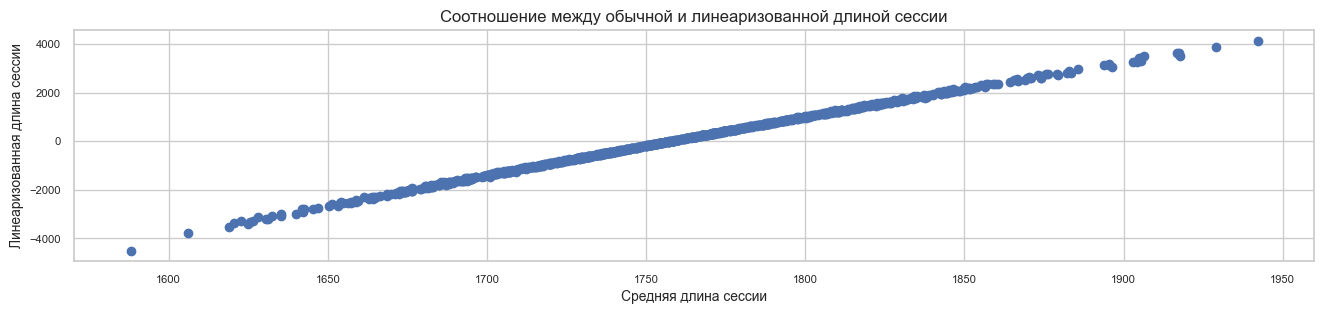

In [16]:
calc_delta['LinearAvgSessionDuration'] = calc_delta['TotalSessionDuration'] - (mean_x / mean_y) * calc_delta['SessionsCnt']

boots_avg, boots_linear = [], []
for _ in tqdm(range(iters)):
    smpl = np.random.choice(calc_delta['user_id'].unique(), boot_sample, replace=False)
    df = calc_delta[calc_delta['user_id'].isin(smpl)].copy()
    avg_session = df['TotalSessionDuration'].sum() / df['SessionsCnt'].sum()
    linear_avg = df['LinearAvgSessionDuration'].mean()
    boots_avg.append(avg_session)
    boots_linear.append(linear_avg)

plt.figure(figsize = (16,3))
plt.scatter(boots_avg, boots_linear)
plt.xlabel('Средняя длина сессии')
plt.ylabel('Линеаризованная длина сессии')
plt.title('Соотношение между обычной и линеаризованной длиной сессии')
plt.show()

При использовании стат. тестов можно получить оценку прироста линеаризованной метрики. Чтобы вернуться в пространство метрики отношения, необходимо разделить прирост линеаризованной метрики на среднее значение знаменателя метрики отношения: 
$$\Delta{X} = \frac{\Delta{L}}{\bar{D}}$$

Соответственно, доверительный интервал метрики отношения рассчитывается на основе границ, которые пересчитываются по формуле:
$$X_i = \frac{\bar{M} - L_i}{\bar{D}},$$ где $L_i$ - граница доверительного интервала метрики.

При планировании дизайна эксперимента, когда определяется **MDE**, то нужно определять MDE именно для линеаризованной метрики. Сделать это можно следующим образом:
* зафиксировать желаемый MDE для исходной метрики отношения $\Delta{X}$;
* перевести его в MDE для линеаризованной метрики по формуле: $\Delta{L} = \Delta{X} \cdot \bar{D}$